# Final Project - Amor, ReyesJ, Servando, Tan, Ventura

## Reinforcement Learning

This reinforcement learning project is centered around an agent navigating an 8x8 grid environment while learning through Q-learning. The system incorporates interactive elements (Enemies from a video game), visual feedbacks, and user interactivity  to enhance both functionality and interpretability.

To guide you with the step-by-step process, let us first beginw by importing all necessary libraries.

The project will not be using custom environemtn libraries, instead, the environment will be set up through manual code, visualized with pygame.

In [ ]:
import platform
import numpy as np
import pygame
import time
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

Before we run the main driver code, we must first mount the drive which will contain the images used in our environemnt.

* Note: Before running, make sure to have uploaded the supplementary content folder in your drive for the notebook to access the images for the visualization of the environment, or else the program will not run.
* Then, you must connect the account you uploaded the content folder to Google Colab

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

image_folder_path = '/content/drive/MyDrive/content'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After a successful run, it is time for the main ingredients of the program.

### Ref1 - Design a Custom Maze Environment

#### __ __init__ __
Below is the main class setting up the MazeEnv class, which will be where all the initialization and methods related to the environment are set up.

Inizialization starts off with developing a grid 2d-array (8 by 8 size) with a starting (S) cell, walls (W), pathways (.), traps (T), portals (P1 and P2), a reward (R), and the goal (G).

It is also indicated the different actions:
* Left - 0
* Right - 1
* Up - 2
* Down - 3

Additionally, the images are also loaded in with PyGame.

After initialization, there are more core functions for interacting with the maze environment:

#### reset():

This method resets the environment to its initial state.

#### _get_state_id(self):
This is simply a helper method to convert the agent's 2D state coordinates (row, column) into a single unique integer ID.

#### step(self, action):

This is the main function for the agent to take action. It takes an action as input and updates the environment's state accordingly. It calculates the new_x and new_y coordinates based on the current state and the chosen action.
* Portal Logic: If the new position is a portal ('P1' or 'P2'), the agent's state is updated to the corresponding portal's destination.
* If the new position is not a wall ('W'), the agent's state is updated, and the new state is added to the self.path.
* It determines the reward based on the cell type of the new state:
  - 10 for reaching the goal ('G').
  - 5 for reaching the reward ('R').
  - -1 for landing on a trap ('T').
  - 0 for moving to an empty cell or a portal.

### Ref4 - Add traps with negative rewards

Inside the step function, there are penalties and rewards added to the reward variable. To implement the reference, traps were scattered in the form of monsters in the environment. This will penalize the agent.

The traps can also be seen indicated in the grid 2d-array.

### Ref9 - Add portals

To add more variability, the group added 2 portals in the environment which can be seen in the initialization. In the step function, it is indicated that entering one portal will lead you to the other and vice versa.

### Ref8 - Visualize Environment

#### render

To introduce real-time visualization, the render method was added, showing the environment in a PyGame display. This fills the screen with a white background, iterates through the grid, and drawing the appropriate image for each cell based on its type (wall, empty, reward, goal, portal, or penalty). It also handles displaying the player's position as well as their path, indicated by the drawn blue lines.

#### save_step_maze

This method generates and saves a static image of the maze state at a specific step, which can be shown in the current Colab environment files. It creates a Pygame Surface which acts as an off-screen drawing area, draws the maze's current status, and saves the content of the surface as a JPEG image using pygame.image.save().

#### save_initial_maze

This is a helper method to specifically save the initial state of the maze at the beginning of an episode or run.

In [ ]:
# Ref1_v2: Custom maze environment
class MazeEnv:
    def __init__(self):
        # Ref1_v2: Define 8x8 grid with start, goal, reward, walls, and penalties
        print("Verbose: Initializing 8x8 maze environment")
        self.grid = [
            ['S', '.', '.', 'W', 'T', '.', '.', '.'],
            ['W', 'W', '.', 'W', '.', 'T', '.', '.'],
            ['.', '.', '.', '.', '.', '.', 'T', '.'],
            ['.', 'W', 'W', 'W', '.', '.', '.', '.'],
            ['.', 'P1', 'T', '.', 'W', '.', 'T', '.'],
            ['.', '.', '.', '.', '.', 'W', '.', '.'],
            ['T', 'W', '.', 'T', '.', '.', '.', 'R'],
            ['.', '.', '.', '.', 'W', 'P2', 'G', '.']
        ]
        #Row x col
        self.grid_size = 8
        self.state = (0, 0)  # Start position
        self.goal_state = (7, 6)  # Goal position
        self.reward_state = (6, 7)  # Reward position
        self.action_space = [0, 1, 2, 3]  # Left, Right, Up, Down
        self.cell_size = 64  # 64x64 pixels per cell for 512x512 total
        self.path = [(0, 0)]  # Track path history
        self.step_count = 0  # Track steps for static image naming

        # Ref1_v2: Load custom images for visualization
        try:
            self.images = {
              'S': pygame.image.load(os.path.join(image_folder_path, "image8.jpg")),  # Player
              'R': pygame.image.load(os.path.join(image_folder_path, "image1.jpg")),  # Reward
              'G': pygame.image.load(os.path.join(image_folder_path, "image2.jpg")),  # Goal
              '.': pygame.Surface((64, 64)),         # Empty
              'W': pygame.Surface((64, 64)),          # Wall

              # Ref9: Portal
              'P1': pygame.image.load(os.path.join(image_folder_path, "image9.jpg")),   # Portal
              'P2': pygame.image.load(os.path.join(image_folder_path, "image9.jpg"))   # Portal
            }
            self.images['.'].fill((255, 255, 255))  # White empty
            self.images['W'].fill((0, 0, 0))        # Black wall
            print("Verbose: Loaded player (image8.jpg), reward (image1.jpg), goal (image2.jpg), empty, and wall images")
            self.penalty_images = [
                pygame.image.load(os.path.join(image_folder_path, "image3.jpg")),
                pygame.image.load(os.path.join(image_folder_path, "image4.jpg")),
                pygame.image.load(os.path.join(image_folder_path, "image5.jpg")),
                pygame.image.load(os.path.join(image_folder_path, "image6.jpg")),
                pygame.image.load(os.path.join(image_folder_path, "image7.jpg"))
              ]
            print("Verbose: Loaded penalty images (image3.jpg to image7.jpg)")
        except FileNotFoundError as e:
            print(f"Verbose: Error loading images: {e}")
            raise
        for key in self.images:
            self.images[key] = pygame.transform.scale(self.images[key], (64, 64))
        for i in range(len(self.penalty_images)):
            self.penalty_images[i] = pygame.transform.scale(self.penalty_images[i], (64, 64))
        self.penalty_map = {}
        penalty_count = 0
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if self.grid[i][j] == 'T':
                    self.penalty_map[(i, j)] = self.penalty_images[penalty_count % 5]
                    penalty_count += 1
        print("Verbose: Images loaded and mapped for penalty tiles: (0,4)=image3.jpg, (1,5)=image4.jpg, (2,6)=image5.jpg, (4,2)=image6.jpg, (4,6)=image7.jpg, (5,0)=image3.jpg")

    # Ref1_v2: Reset environment to start state
    def reset(self):
        print("Verbose: Resetting environment")
        self.state = (0, 0)
        self.path = [(0, 0)]
        self.step_count = 0
        return self._get_state_id()

    # Ref1_v2: Convert state coordinates to ID
    def _get_state_id(self):
        return self.state[0] * self.grid_size + self.state[1]

    # Ref1_v2, Ref4: Step function with movement and reward logic (including penalties)
    def step(self, action):
        self.step_count += 1
        x, y = self.state
        new_x, new_y = x, y
        if action == 0: new_y -= 1  # Left
        elif action == 1: new_y += 1  # Right
        elif action == 2: new_x -= 1  # Up
        elif action == 3: new_x += 1  # Down

        reward = 0
        done = False
        if 0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size:
              # Ref9: Portal
            if self.grid[new_x][new_y] == 'P1': # Portal going to Portal 2
                new_x, new_y = (7, 5)
            elif self.grid[new_x][new_y] == 'P2': # Portal going to Portal 1
                new_x, new_y = (4, 1)


            if self.grid[new_x][new_y] != 'W':
                self.state = (new_x, new_y)
                self.path.append(self.state)

        cell = self.grid[self.state[0]][self.state[1]]
        if self.state == self.goal_state:
            reward = 10
            done = True
        elif self.state == self.reward_state:
            reward = 5
        elif cell == 'T':
            reward = -1  # Ref4: Uniform penalty rewar



        return self._get_state_id(), reward, done, {}, {}

    # Ref8: Pygame Visualization of Path Taken
    def render(self, screen, mode="training", episode=0):
        print(f"Verbose: Rendering maze with custom images in Pygame window (mode: {mode}, episode: {episode}, step: {self.step_count})")
        screen.fill((255, 255, 255))
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                cell_type = self.grid[i][j]
                if (i, j) == self.state and cell_type != 'S':
                    cell_type = 'S'
                if cell_type == 'T':
                    screen.blit(self.penalty_map[(i, j)], (j * self.cell_size, i * self.cell_size))
                else:
                    screen.blit(self.images[cell_type], (j * self.cell_size, i * self.cell_size))
        for i in range(len(self.path) - 1):
            x1, y1 = self.path[i]
            x2, y2 = self.path[i + 1]
            pygame.draw.line(screen, (0, 0, 255),
                           (y1 * self.cell_size + self.cell_size // 2,
                            x1 * self.cell_size + self.cell_size // 2),
                           (y2 * self.cell_size + self.cell_size // 2,
                            x2 * self.cell_size + self.cell_size // 2), 8)
        pygame.display.update()
        print(f"Verbose: Pygame display updated (mode: {mode}, episode: {episode}, step: {self.step_count})")
        self.save_step_maze(mode, episode)

    def save_step_maze(self, mode="training", episode=0, filename=None):
        if filename is None:
            filename = f"maze_step_{episode}_{self.step_count}.jpg"
        print(f"Verbose: Generating static maze visualization as {filename}")
        surface = pygame.Surface((512, 512))
        surface.fill((255, 255, 255))
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                cell_type = self.grid[i][j]
                if (i, j) == self.state and cell_type != 'S':
                    cell_type = 'S'
                if cell_type == 'T':
                    surface.blit(self.penalty_map[(i, j)], (j * self.cell_size, i * self.cell_size))
                else:
                    surface.blit(self.images[cell_type], (j * self.cell_size, i * self.cell_size))
        for i in range(len(self.path) - 1):
            x1, y1 = self.path[i]
            x2, y2 = self.path[i + 1]
            pygame.draw.line(surface, (0, 0, 255),
                           (y1 * self.cell_size + self.cell_size // 2,
                            x1 * self.cell_size + self.cell_size // 2),
                           (y2 * self.cell_size + self.cell_size // 2,
                            x2 * self.cell_size + self.cell_size // 2), 8)
        try:
            pygame.image.save(surface, filename)
            print(f"Verbose: Static maze saved as {filename} in {os.getcwd()}")
            if platform.system() != "Emscripten" and Image and display:
                try:
                    display(Image(filename))
                    print(f"Verbose: Displaying static maze {filename} in Jupyter")
                except Exception as e:
                    print(f"Verbose: Failed to display static maze {filename} in Jupyter: {e}")
                    print(f"Verbose: Please check {filename} in {os.getcwd()}")
            else:
                print(f"Verbose: Please check {filename} in {os.getcwd()}")
        except Exception as e:
            print(f"Verbose: Failed to save static maze {filename}: {e}")

    def save_initial_maze(self, filename="initial_maze.jpg"):
        print(f"Verbose: Generating initial static maze visualization as {filename}")
        self.step_count = 0
        self.save_step_maze(mode="initial", episode=0, filename=filename)

### Ref5: Key Metrics for Q-Learning performance

Below are the initial variables set before Q-Learning begins. This simply initializes all the variables to use at the start. Additionally, empty lists below were declared and will be populated, these are the metrics for Q-learning including:
* Average Reward per Episode.
* Episode Length.
* Cumulative Reward.
* Success Rate
* Epsilon Decay


In [ ]:
# Ref5: Q-learning setup with epsilon decay and performance metrics
state_size = 64
action_size = 4
q_table = np.zeros((state_size, action_size))
alpha = 0.8
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
episodes = 100
FPS = 120

epsilons = []
rewards = []
successes = 0
q_changes = []
prev_q_table = q_table.copy()
average_reward_per_episode = []
success_rate = []
episode_lengths = []

The code below simply initializes the pygame display when it comes to training the Q-Learning model.

In [ ]:
# Pygame setup
print("Verbose: Initializing Pygame")
try:
    pygame.init()
    screen = pygame.display.set_mode((512, 512))
    pygame.display.set_caption("Maze Visualization")
    print("Verbose: Pygame window created (512x512 pixels)")
except Exception as e:
    print(f"Verbose: Failed to initialize Pygame: {e}")
    raise

Verbose: Initializing Pygame
Verbose: Pygame window created (512x512 pixels)


### Ref10: Replay function using saved actions

The function below adds a replay feature that records sequences of user or agent actions and allows them to be replayed visually. It will essentially just run the entire code taking in the user input in the next few cells.

In [ ]:
# Ref10: Replay function using saved actions
action_list = []
def replay_maze(actions_list):
    print("Verbose: Entering replay_maze function")
    state = env.reset()
    done = False
    replay_step_count = 0
    print("Verbose: Starting replay...")

    env.save_step_maze(mode="replay", episode=0, filename="maze_replay_start.jpg")

    for action in actions_list:
        if done:
            print("Verbose: Replay reached a terminal state. Stopping replay.")
            break
        next_state, reward, done, _, _ = env.step(action)
        state = next_state
        replay_step_count += 1
        env.save_step_maze(mode="replay", episode=0, filename=f"maze_replay_step_{replay_step_count}.jpg")
        print(f"Verbose: Replay step {replay_step_count}, action: {action}, state: {state}, reward: {reward}, done: {done}")

    print("Verbose: Replay completed.")

For the next big ingredient, it will be the driver function. We must first setup the environment, creating a variable env.

### Ref2: Epsilon Decay

Located near the end of the for loop of episodes is the code logic for epsilon decay, which takes the larger value between the default epsilon, and the one applied with decay to update the value. This reduces epsilon over time, but never lets it fall below the minimum epsilon. It ensures that the agent gradually shifts from exploring the environment to exploiting what it has already learned.

### Ref5: Key Metrics

WIthin the function of main, there are append statements which populate the metrics defined earlier. This will be used to track the Q-learning performance over the episodes.

### Ref 7: How to test the model with user input

After the training is done (The for loop), the next step is the while loop, which allows the user to interact with the environment, in a way playing with it as well. They can move, get rewards, get trapped, enter portals, and will finish once they enter the goal cell.

In [ ]:
def setup():
    global env
    print("Verbose: Setting up environment")
    env = MazeEnv()
    env.save_initial_maze()

# Ref2, Ref7_v1: Main training and testing loop (Ref3, Ref6 disabled)
def main():
    global epsilon, epsilons, rewards, episode_lengths, average_reward_per_episode, success_rate, successes, q_changes, prev_q_table, q_table, action_list
    print("Verbose: Entering main function")
    print("Verbose: Starting training")
    # Ref2, Ref5: Q-learning training with epsilon decay and metrics
    for episode in range(episodes):
        print(f"Verbose: Starting episode {episode + 1}/{episodes}")
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        while not done:
            # Ref2: Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = np.random.choice(env.action_space)
            else:
                action = np.argmax(q_table[state])
            next_state, reward, done, _, _ = env.step(action)
            q_table[state, action] += alpha * (
                reward + gamma * np.max(q_table[next_state]) - q_table[state, action]
            )
            state = next_state
            total_reward += reward
            steps += 1
            # *** FIX: COMMENT OUT PYGAME DISPLAY RENDER CALL ***
            #env.render(screen, mode="training", episode=episode + 1)
            #time.sleep(1.0 / FPS) # Sleep is also for live display
            # *** Consider adding env.save_step_maze() here if you want to save every single step visualization during training ***
            #env.save_step_maze(mode="training", episode=episode + 1) # Uncomment if you want to save every step

        # Ref5: Track performance metrics
        epsilons.append(epsilon)
        rewards.append(total_reward)
        average_reward_per_episode.append(total_reward / steps)

        success_rate.append(successes / (episode + 1))
        episode_lengths.append(steps)
        if total_reward >= 10:  # Success if goal reached
            successes += 1
        q_changes.append(np.linalg.norm(q_table - prev_q_table))
        prev_q_table = q_table.copy()
        # Ref2: Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        print(f"Verbose: Episode {episode + 1} completed, total reward: {total_reward}, steps: {steps}")
        # *** FIX: Save the final state of the episode after training ***
        env.save_step_maze(mode="training_final", episode=episode + 1, filename=f"maze_episode_final_{episode + 1}.jpg")


    print("Verbose: Training completed")

    # Ref7_v1: Manual testing mode
    print("Verbose: Starting manual testing mode")
    state = env.reset()
    done = False
    print("Manual testing started. Choose actions:")

    # *** FIX: Save the initial state for manual testing ***
    env.save_step_maze(mode="manual", episode=0, filename="maze_manual_start.jpg")

    manual_step_count = 0
    while not done:
        # *** FIX: COMMENT OUT PYGAME DISPLAY RENDER CALL ***
       # env.render(screen, mode="manual", episode=0)
        try:
            print("Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):")
            user_input = input()
            user_action = int(user_input)
            if user_action == -1:
                print("Verbose: Exiting manual testing")
                break
            if user_action not in [0, 1, 2, 3]:
                print("Verbose: Invalid action. Please enter 0 to 3.")
                continue
        except ValueError:
            print("Verbose: Invalid input. Please enter an integer.")
            continue

        next_state, reward, done, _, _ = env.step(user_action)
        print(f"Verbose: Moved to state {next_state}, reward: {reward}, done: {done}")
        action_list.append(user_action)
        state = next_state
        # *** FIX: Save the state after each manual step ***
        manual_step_count += 1
        env.save_step_maze(mode="manual", episode=0, filename=f"maze_manual_step_{manual_step_count}.jpg")
        #time.sleep(1.0 / FPS) # Sleep is for live display, not needed for static save

    print("Verbose: Manual testing completed")

Below is the driver code that calls the setup and training process. To make sure the program runs without errors, we implemented exception handling to catch these errors. As seen below, a bunch of images showing the agent's path throughout the episodes are displayed.

At the very end, the Q-Learning finishes, and we essentially get to play!

Verbose: Starting execution
Verbose: Running in local environment
Verbose: Setting up environment
Verbose: Initializing 8x8 maze environment
Verbose: Loaded player (image8.jpg), reward (image1.jpg), goal (image2.jpg), empty, and wall images
Verbose: Loaded penalty images (image3.jpg to image7.jpg)
Verbose: Images loaded and mapped for penalty tiles: (0,4)=image3.jpg, (1,5)=image4.jpg, (2,6)=image5.jpg, (4,2)=image6.jpg, (4,6)=image7.jpg, (5,0)=image3.jpg
Verbose: Generating initial static maze visualization as initial_maze.jpg
Verbose: Generating static maze visualization as initial_maze.jpg
Verbose: Static maze saved as initial_maze.jpg in /content


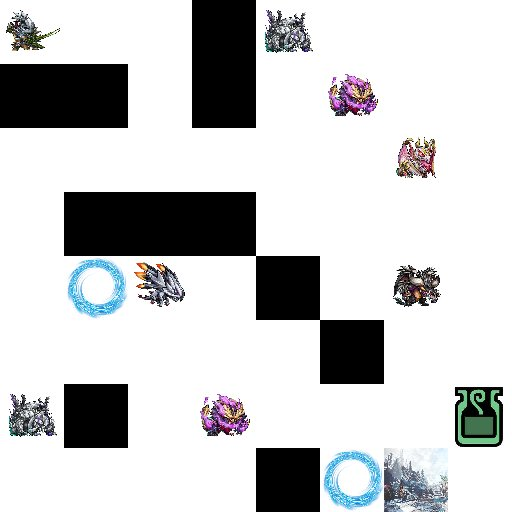

Verbose: Displaying static maze initial_maze.jpg in Jupyter
Verbose: Entering main function
Verbose: Starting training
Verbose: Starting episode 1/100
Verbose: Resetting environment
Verbose: Episode 1 completed, total reward: 2, steps: 134
Verbose: Generating static maze visualization as maze_episode_final_1.jpg
Verbose: Static maze saved as maze_episode_final_1.jpg in /content


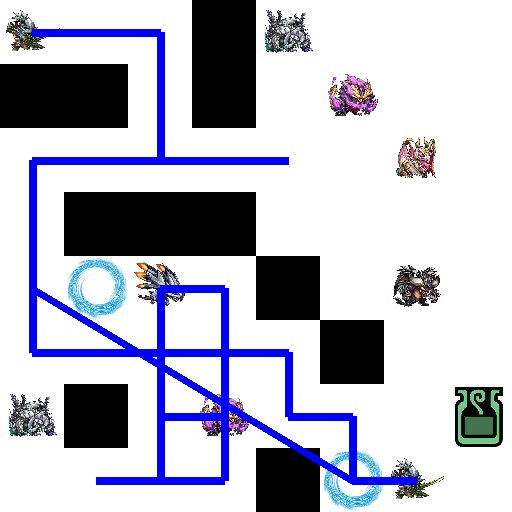

Verbose: Displaying static maze maze_episode_final_1.jpg in Jupyter
Verbose: Starting episode 2/100
Verbose: Resetting environment
Verbose: Episode 2 completed, total reward: -71, steps: 525
Verbose: Generating static maze visualization as maze_episode_final_2.jpg
Verbose: Static maze saved as maze_episode_final_2.jpg in /content


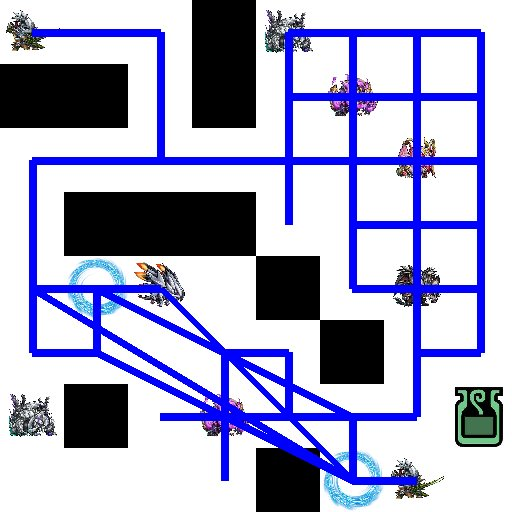

Verbose: Displaying static maze maze_episode_final_2.jpg in Jupyter
Verbose: Starting episode 3/100
Verbose: Resetting environment
Verbose: Episode 3 completed, total reward: 2, steps: 139
Verbose: Generating static maze visualization as maze_episode_final_3.jpg
Verbose: Static maze saved as maze_episode_final_3.jpg in /content


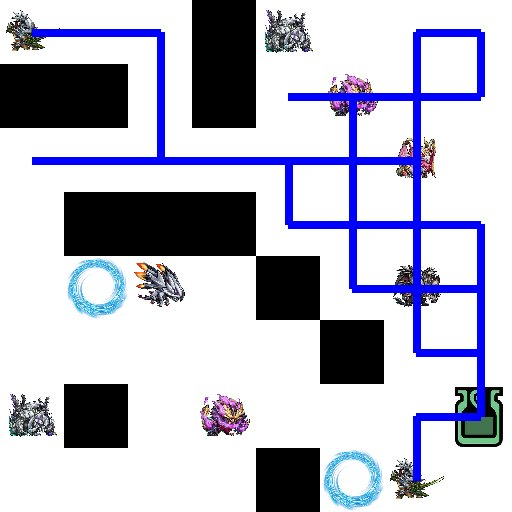

Verbose: Displaying static maze maze_episode_final_3.jpg in Jupyter
Verbose: Starting episode 4/100
Verbose: Resetting environment
Verbose: Episode 4 completed, total reward: 33, steps: 168
Verbose: Generating static maze visualization as maze_episode_final_4.jpg
Verbose: Static maze saved as maze_episode_final_4.jpg in /content


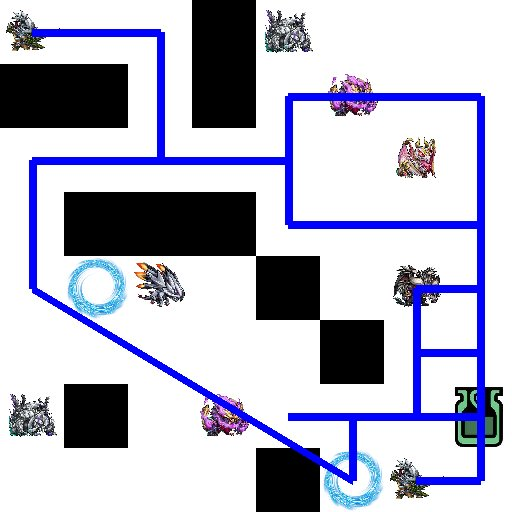

Verbose: Displaying static maze maze_episode_final_4.jpg in Jupyter
Verbose: Starting episode 5/100
Verbose: Resetting environment
Verbose: Episode 5 completed, total reward: 22, steps: 238
Verbose: Generating static maze visualization as maze_episode_final_5.jpg
Verbose: Static maze saved as maze_episode_final_5.jpg in /content


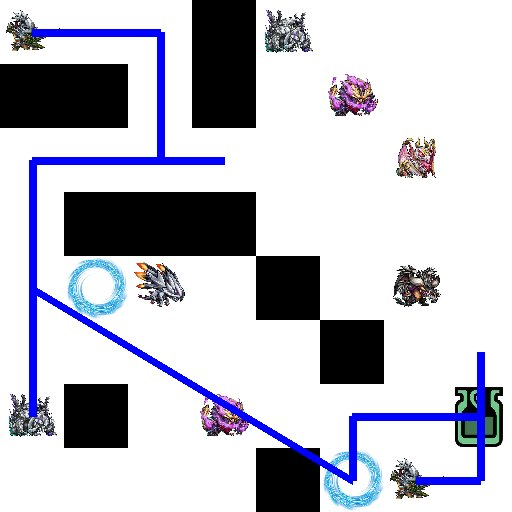

Verbose: Displaying static maze maze_episode_final_5.jpg in Jupyter
Verbose: Starting episode 6/100
Verbose: Resetting environment
Verbose: Episode 6 completed, total reward: 27, steps: 261
Verbose: Generating static maze visualization as maze_episode_final_6.jpg
Verbose: Static maze saved as maze_episode_final_6.jpg in /content


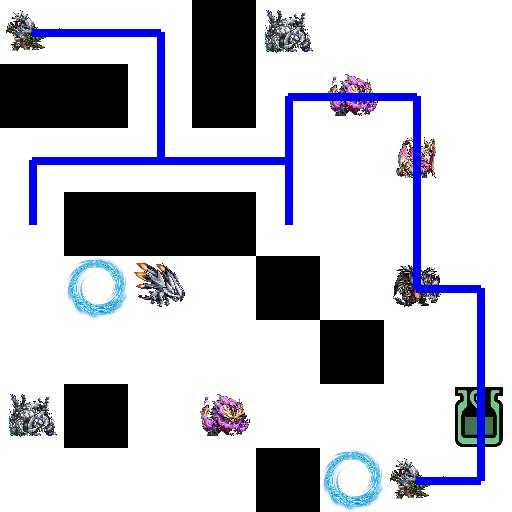

Verbose: Displaying static maze maze_episode_final_6.jpg in Jupyter
Verbose: Starting episode 7/100
Verbose: Resetting environment
Verbose: Episode 7 completed, total reward: 6, steps: 105
Verbose: Generating static maze visualization as maze_episode_final_7.jpg
Verbose: Static maze saved as maze_episode_final_7.jpg in /content


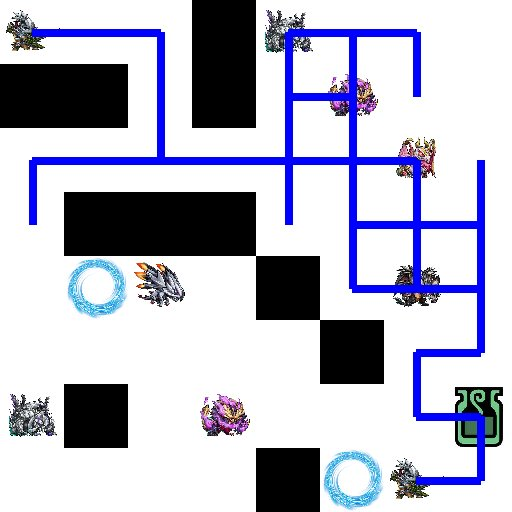

Verbose: Displaying static maze maze_episode_final_7.jpg in Jupyter
Verbose: Starting episode 8/100
Verbose: Resetting environment
Verbose: Episode 8 completed, total reward: -24, steps: 213
Verbose: Generating static maze visualization as maze_episode_final_8.jpg
Verbose: Static maze saved as maze_episode_final_8.jpg in /content


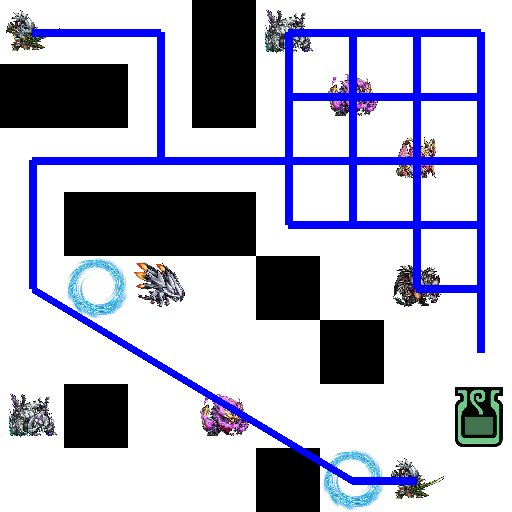

Verbose: Displaying static maze maze_episode_final_8.jpg in Jupyter
Verbose: Starting episode 9/100
Verbose: Resetting environment
Verbose: Episode 9 completed, total reward: 6, steps: 34
Verbose: Generating static maze visualization as maze_episode_final_9.jpg
Verbose: Static maze saved as maze_episode_final_9.jpg in /content


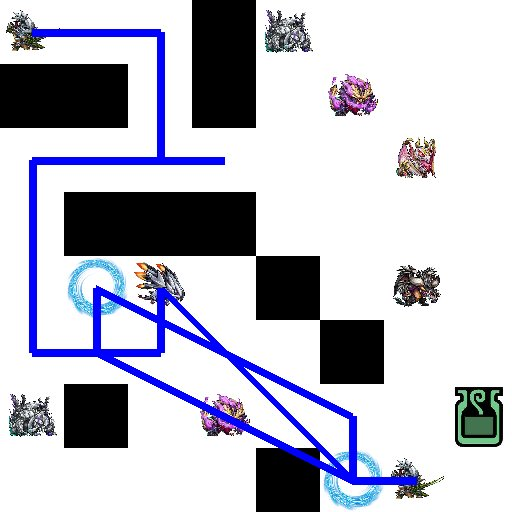

Verbose: Displaying static maze maze_episode_final_9.jpg in Jupyter
Verbose: Starting episode 10/100
Verbose: Resetting environment
Verbose: Episode 10 completed, total reward: -6, steps: 64
Verbose: Generating static maze visualization as maze_episode_final_10.jpg
Verbose: Static maze saved as maze_episode_final_10.jpg in /content


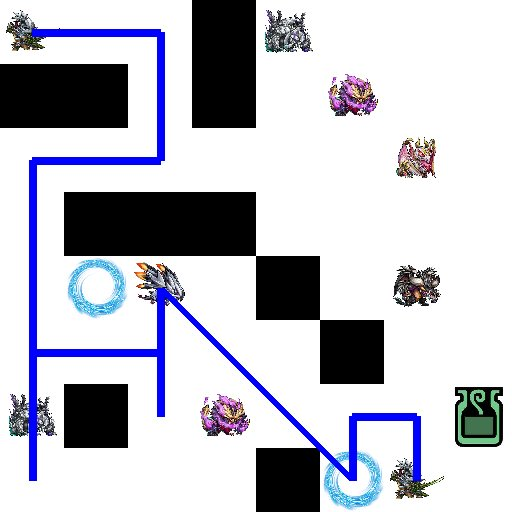

Verbose: Displaying static maze maze_episode_final_10.jpg in Jupyter
Verbose: Starting episode 11/100
Verbose: Resetting environment
Verbose: Episode 11 completed, total reward: 23, steps: 136
Verbose: Generating static maze visualization as maze_episode_final_11.jpg
Verbose: Static maze saved as maze_episode_final_11.jpg in /content


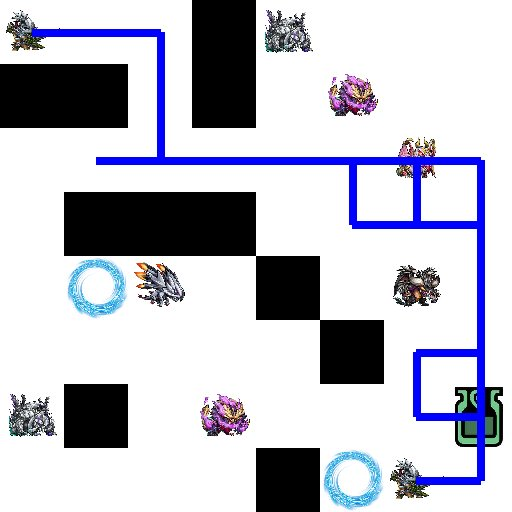

Verbose: Displaying static maze maze_episode_final_11.jpg in Jupyter
Verbose: Starting episode 12/100
Verbose: Resetting environment
Verbose: Episode 12 completed, total reward: 10, steps: 169
Verbose: Generating static maze visualization as maze_episode_final_12.jpg
Verbose: Static maze saved as maze_episode_final_12.jpg in /content


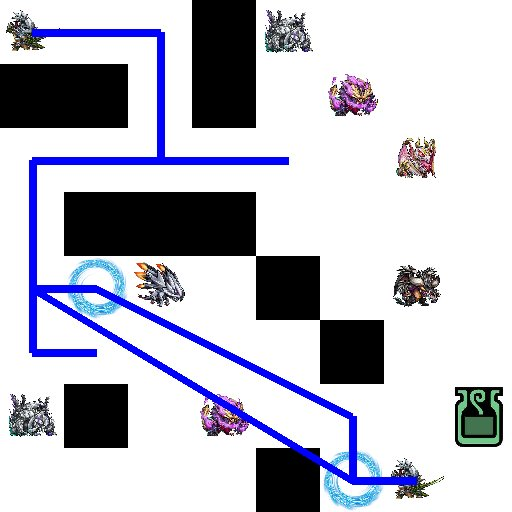

Verbose: Displaying static maze maze_episode_final_12.jpg in Jupyter
Verbose: Starting episode 13/100
Verbose: Resetting environment
Verbose: Episode 13 completed, total reward: -9, steps: 472
Verbose: Generating static maze visualization as maze_episode_final_13.jpg
Verbose: Static maze saved as maze_episode_final_13.jpg in /content


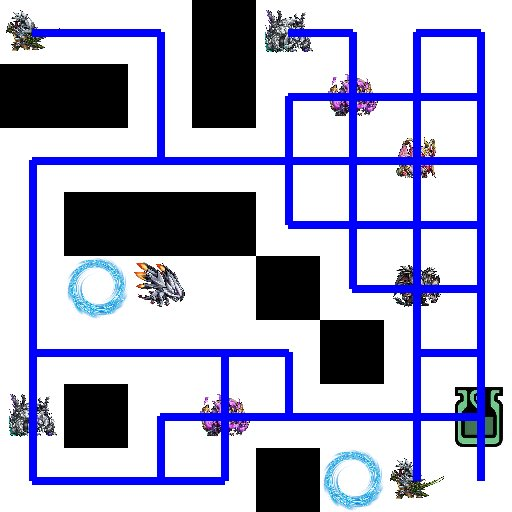

Verbose: Displaying static maze maze_episode_final_13.jpg in Jupyter
Verbose: Starting episode 14/100
Verbose: Resetting environment
Verbose: Episode 14 completed, total reward: 37, steps: 113
Verbose: Generating static maze visualization as maze_episode_final_14.jpg
Verbose: Static maze saved as maze_episode_final_14.jpg in /content


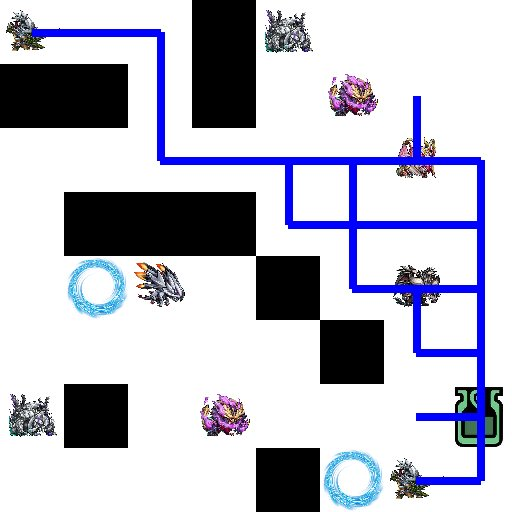

Verbose: Displaying static maze maze_episode_final_14.jpg in Jupyter
Verbose: Starting episode 15/100
Verbose: Resetting environment
Verbose: Episode 15 completed, total reward: 10, steps: 117
Verbose: Generating static maze visualization as maze_episode_final_15.jpg
Verbose: Static maze saved as maze_episode_final_15.jpg in /content


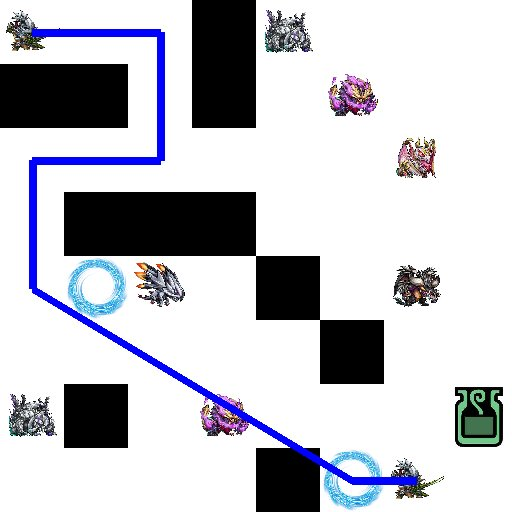

Verbose: Displaying static maze maze_episode_final_15.jpg in Jupyter
Verbose: Starting episode 16/100
Verbose: Resetting environment
Verbose: Episode 16 completed, total reward: -2, steps: 160
Verbose: Generating static maze visualization as maze_episode_final_16.jpg
Verbose: Static maze saved as maze_episode_final_16.jpg in /content


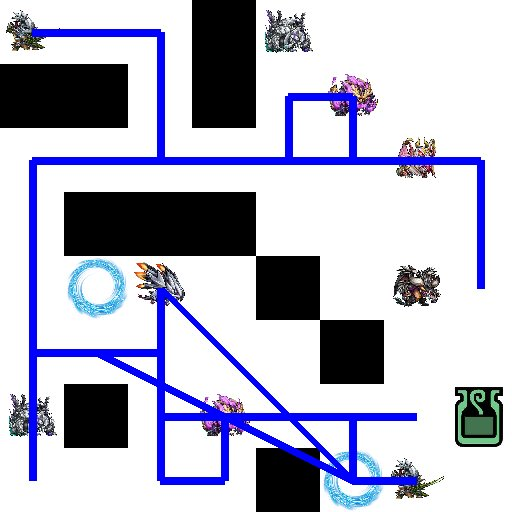

Verbose: Displaying static maze maze_episode_final_16.jpg in Jupyter
Verbose: Starting episode 17/100
Verbose: Resetting environment
Verbose: Episode 17 completed, total reward: 27, steps: 87
Verbose: Generating static maze visualization as maze_episode_final_17.jpg
Verbose: Static maze saved as maze_episode_final_17.jpg in /content


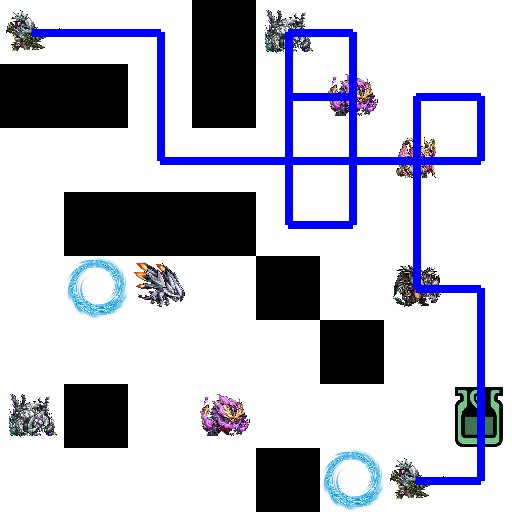

Verbose: Displaying static maze maze_episode_final_17.jpg in Jupyter
Verbose: Starting episode 18/100
Verbose: Resetting environment
Verbose: Episode 18 completed, total reward: 9, steps: 36
Verbose: Generating static maze visualization as maze_episode_final_18.jpg
Verbose: Static maze saved as maze_episode_final_18.jpg in /content


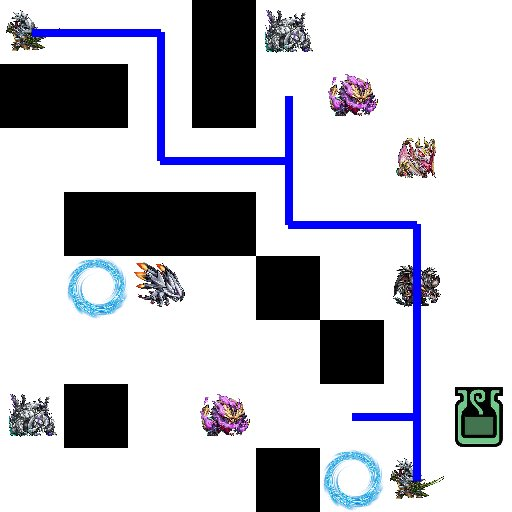

Verbose: Displaying static maze maze_episode_final_18.jpg in Jupyter
Verbose: Starting episode 19/100
Verbose: Resetting environment
Verbose: Episode 19 completed, total reward: -3, steps: 110
Verbose: Generating static maze visualization as maze_episode_final_19.jpg
Verbose: Static maze saved as maze_episode_final_19.jpg in /content


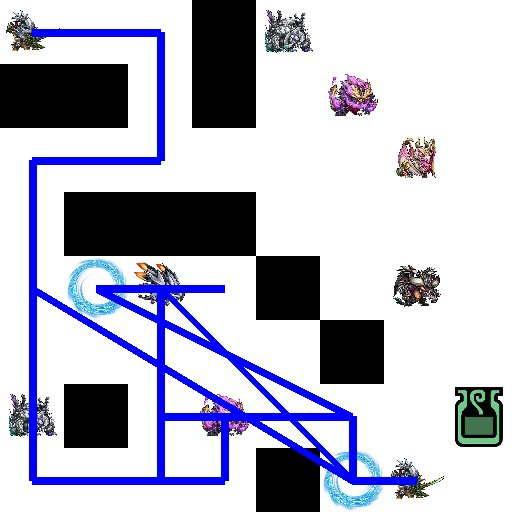

Verbose: Displaying static maze maze_episode_final_19.jpg in Jupyter
Verbose: Starting episode 20/100
Verbose: Resetting environment
Verbose: Episode 20 completed, total reward: 25, steps: 141
Verbose: Generating static maze visualization as maze_episode_final_20.jpg
Verbose: Static maze saved as maze_episode_final_20.jpg in /content


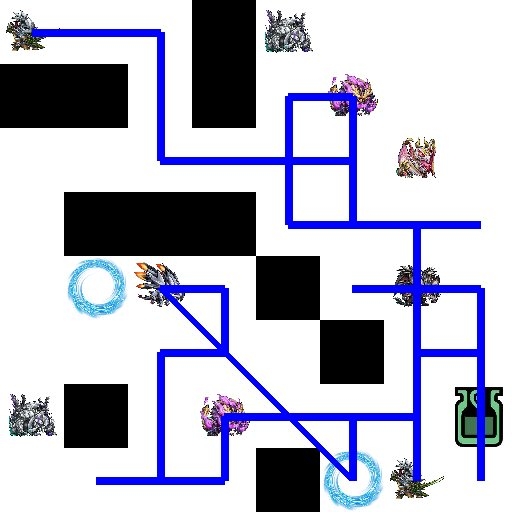

Verbose: Displaying static maze maze_episode_final_20.jpg in Jupyter
Verbose: Starting episode 21/100
Verbose: Resetting environment
Verbose: Episode 21 completed, total reward: 6, steps: 171
Verbose: Generating static maze visualization as maze_episode_final_21.jpg
Verbose: Static maze saved as maze_episode_final_21.jpg in /content


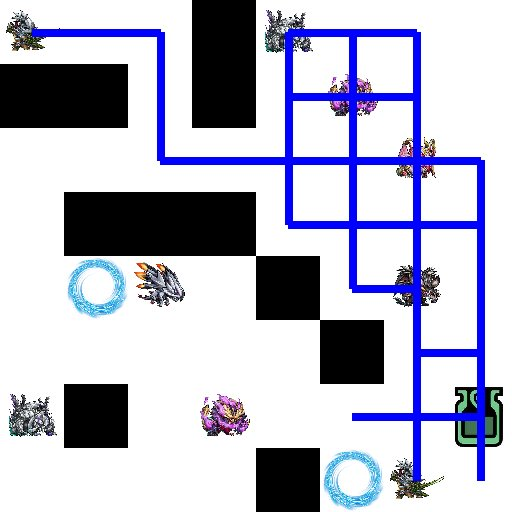

Verbose: Displaying static maze maze_episode_final_21.jpg in Jupyter
Verbose: Starting episode 22/100
Verbose: Resetting environment
Verbose: Episode 22 completed, total reward: 32, steps: 191
Verbose: Generating static maze visualization as maze_episode_final_22.jpg
Verbose: Static maze saved as maze_episode_final_22.jpg in /content


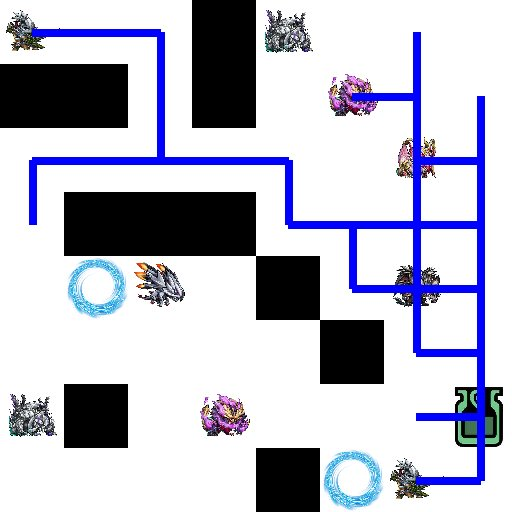

Verbose: Displaying static maze maze_episode_final_22.jpg in Jupyter
Verbose: Starting episode 23/100
Verbose: Resetting environment
Verbose: Episode 23 completed, total reward: 5, steps: 55
Verbose: Generating static maze visualization as maze_episode_final_23.jpg
Verbose: Static maze saved as maze_episode_final_23.jpg in /content


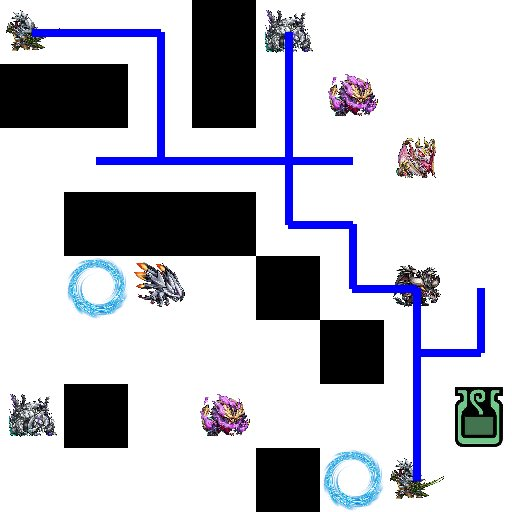

Verbose: Displaying static maze maze_episode_final_23.jpg in Jupyter
Verbose: Starting episode 24/100
Verbose: Resetting environment
Verbose: Episode 24 completed, total reward: 43, steps: 237
Verbose: Generating static maze visualization as maze_episode_final_24.jpg
Verbose: Static maze saved as maze_episode_final_24.jpg in /content


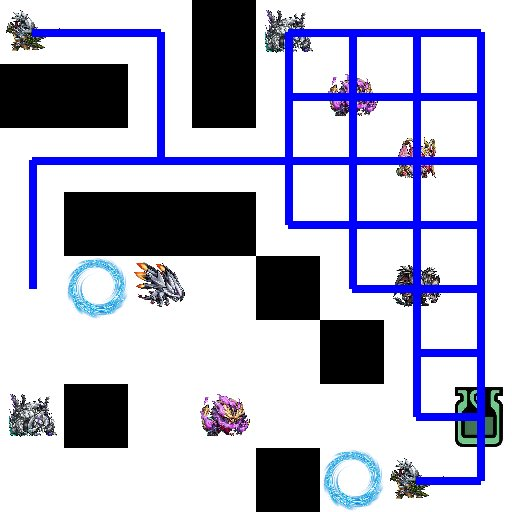

Verbose: Displaying static maze maze_episode_final_24.jpg in Jupyter
Verbose: Starting episode 25/100
Verbose: Resetting environment
Verbose: Episode 25 completed, total reward: 26, steps: 113
Verbose: Generating static maze visualization as maze_episode_final_25.jpg
Verbose: Static maze saved as maze_episode_final_25.jpg in /content


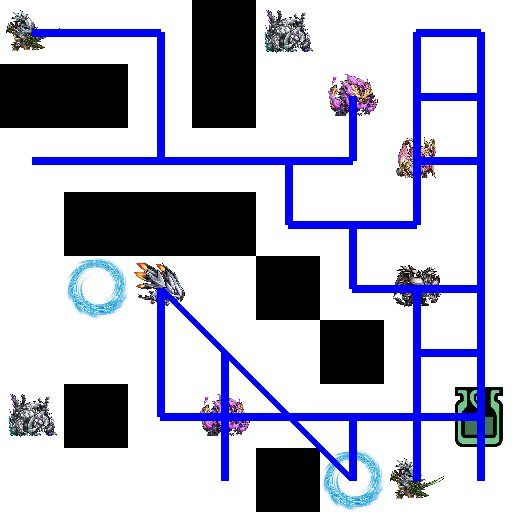

Verbose: Displaying static maze maze_episode_final_25.jpg in Jupyter
Verbose: Starting episode 26/100
Verbose: Resetting environment
Verbose: Episode 26 completed, total reward: 27, steps: 76
Verbose: Generating static maze visualization as maze_episode_final_26.jpg
Verbose: Static maze saved as maze_episode_final_26.jpg in /content


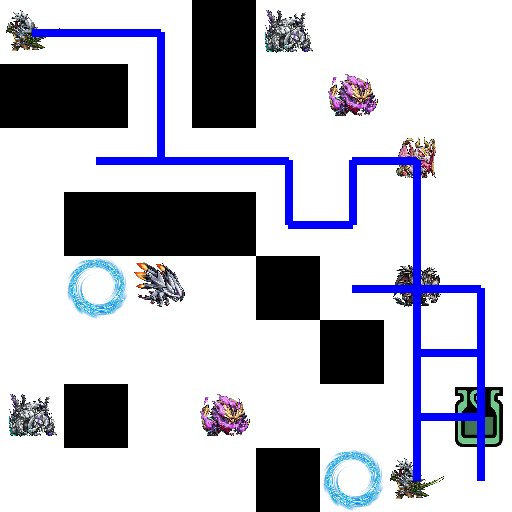

Verbose: Displaying static maze maze_episode_final_26.jpg in Jupyter
Verbose: Starting episode 27/100
Verbose: Resetting environment
Verbose: Episode 27 completed, total reward: 18, steps: 91
Verbose: Generating static maze visualization as maze_episode_final_27.jpg
Verbose: Static maze saved as maze_episode_final_27.jpg in /content


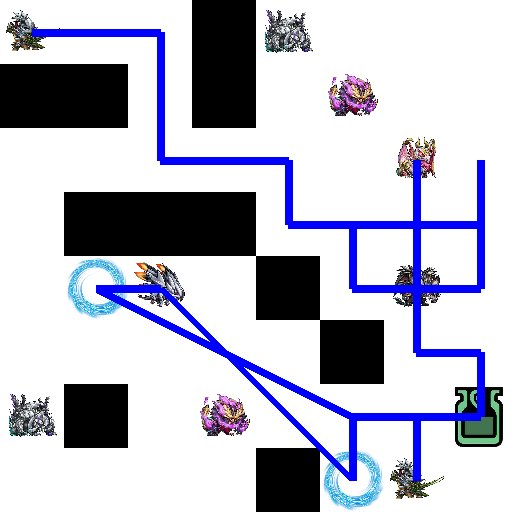

Verbose: Displaying static maze maze_episode_final_27.jpg in Jupyter
Verbose: Starting episode 28/100
Verbose: Resetting environment
Verbose: Episode 28 completed, total reward: 30, steps: 162
Verbose: Generating static maze visualization as maze_episode_final_28.jpg
Verbose: Static maze saved as maze_episode_final_28.jpg in /content


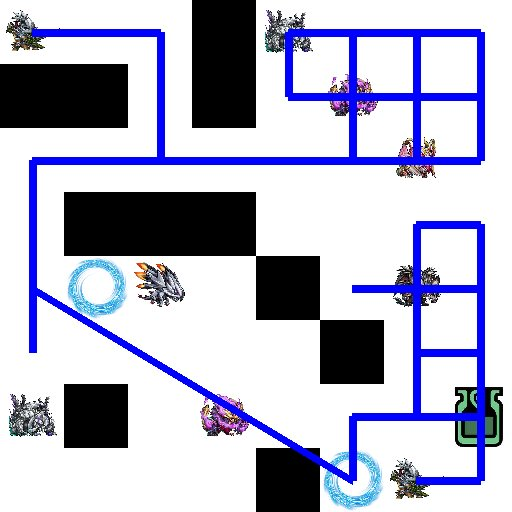

Verbose: Displaying static maze maze_episode_final_28.jpg in Jupyter
Verbose: Starting episode 29/100
Verbose: Resetting environment
Verbose: Episode 29 completed, total reward: 28, steps: 46
Verbose: Generating static maze visualization as maze_episode_final_29.jpg
Verbose: Static maze saved as maze_episode_final_29.jpg in /content


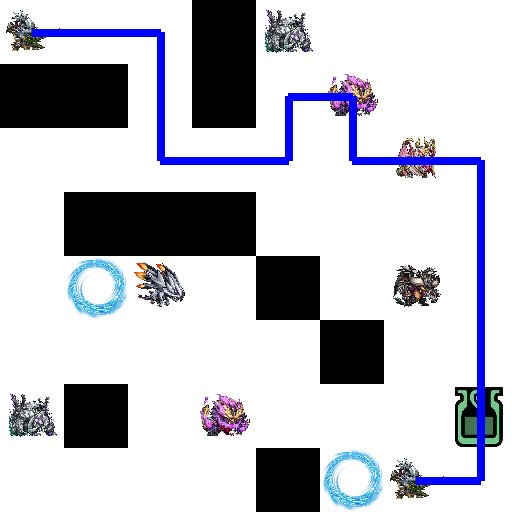

Verbose: Displaying static maze maze_episode_final_29.jpg in Jupyter
Verbose: Starting episode 30/100
Verbose: Resetting environment
Verbose: Episode 30 completed, total reward: 22, steps: 49
Verbose: Generating static maze visualization as maze_episode_final_30.jpg
Verbose: Static maze saved as maze_episode_final_30.jpg in /content


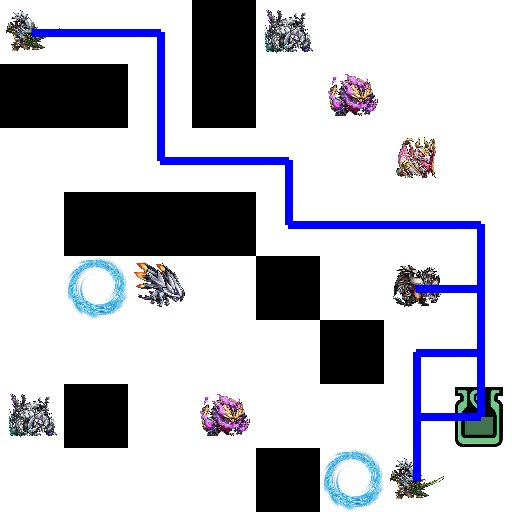

Verbose: Displaying static maze maze_episode_final_30.jpg in Jupyter
Verbose: Starting episode 31/100
Verbose: Resetting environment
Verbose: Episode 31 completed, total reward: 6, steps: 66
Verbose: Generating static maze visualization as maze_episode_final_31.jpg
Verbose: Static maze saved as maze_episode_final_31.jpg in /content


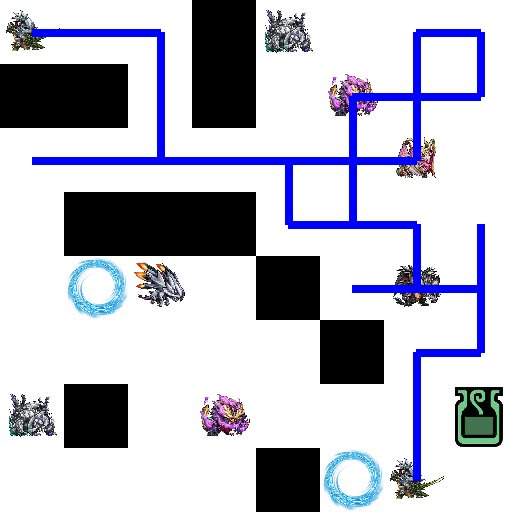

Verbose: Displaying static maze maze_episode_final_31.jpg in Jupyter
Verbose: Starting episode 32/100
Verbose: Resetting environment
Verbose: Episode 32 completed, total reward: 8, steps: 185
Verbose: Generating static maze visualization as maze_episode_final_32.jpg
Verbose: Static maze saved as maze_episode_final_32.jpg in /content


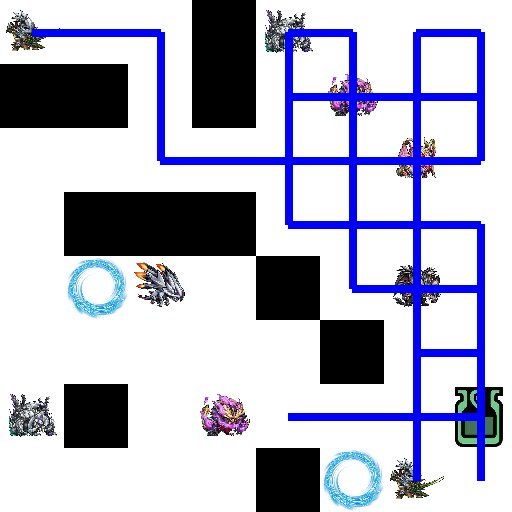

Verbose: Displaying static maze maze_episode_final_32.jpg in Jupyter
Verbose: Starting episode 33/100
Verbose: Resetting environment
Verbose: Episode 33 completed, total reward: 9, steps: 43
Verbose: Generating static maze visualization as maze_episode_final_33.jpg
Verbose: Static maze saved as maze_episode_final_33.jpg in /content


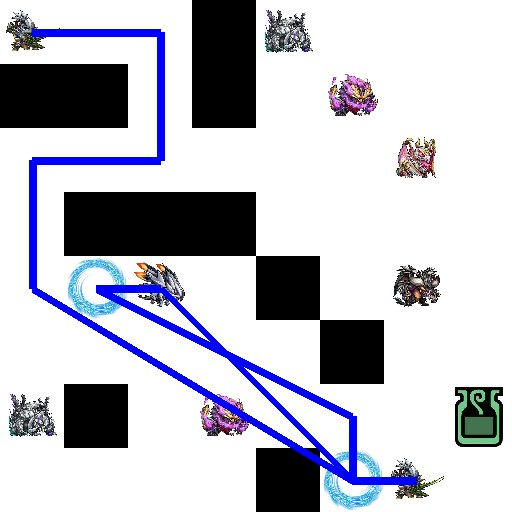

Verbose: Displaying static maze maze_episode_final_33.jpg in Jupyter
Verbose: Starting episode 34/100
Verbose: Resetting environment
Verbose: Episode 34 completed, total reward: 13, steps: 133
Verbose: Generating static maze visualization as maze_episode_final_34.jpg
Verbose: Static maze saved as maze_episode_final_34.jpg in /content


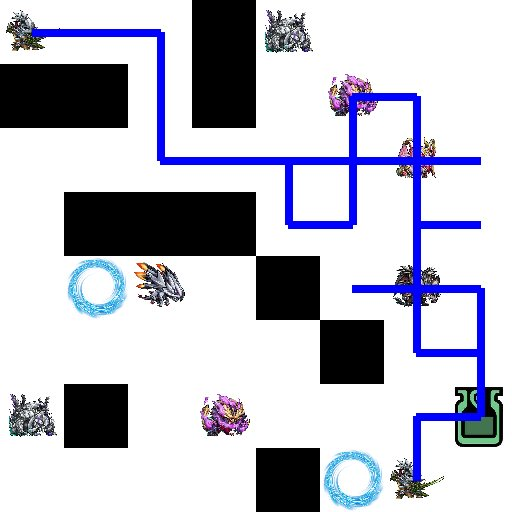

Verbose: Displaying static maze maze_episode_final_34.jpg in Jupyter
Verbose: Starting episode 35/100
Verbose: Resetting environment
Verbose: Episode 35 completed, total reward: 22, steps: 91
Verbose: Generating static maze visualization as maze_episode_final_35.jpg
Verbose: Static maze saved as maze_episode_final_35.jpg in /content


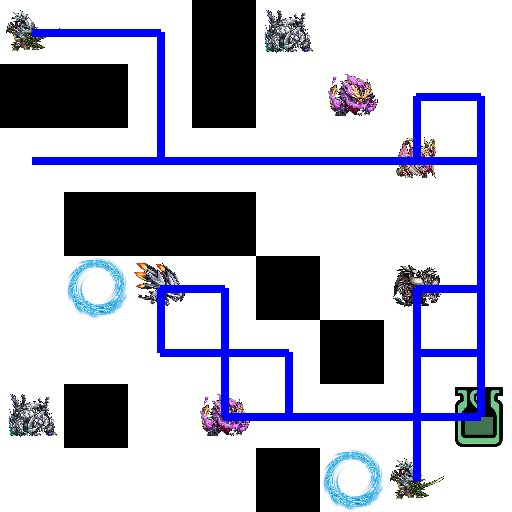

Verbose: Displaying static maze maze_episode_final_35.jpg in Jupyter
Verbose: Starting episode 36/100
Verbose: Resetting environment
Verbose: Episode 36 completed, total reward: 21, steps: 68
Verbose: Generating static maze visualization as maze_episode_final_36.jpg
Verbose: Static maze saved as maze_episode_final_36.jpg in /content


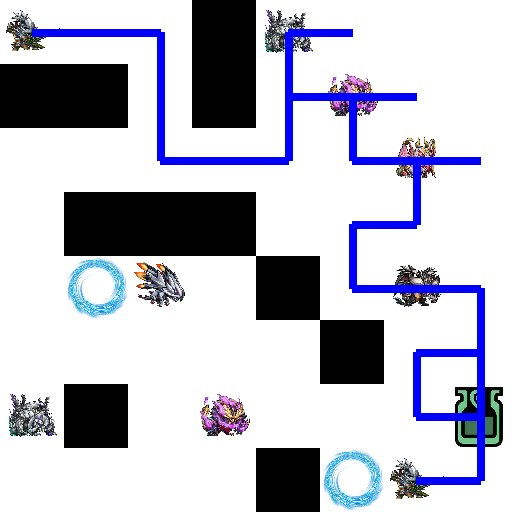

Verbose: Displaying static maze maze_episode_final_36.jpg in Jupyter
Verbose: Starting episode 37/100
Verbose: Resetting environment
Verbose: Episode 37 completed, total reward: 31, steps: 119
Verbose: Generating static maze visualization as maze_episode_final_37.jpg
Verbose: Static maze saved as maze_episode_final_37.jpg in /content


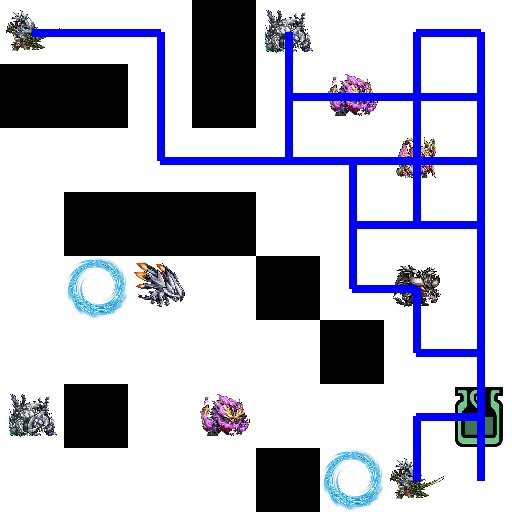

Verbose: Displaying static maze maze_episode_final_37.jpg in Jupyter
Verbose: Starting episode 38/100
Verbose: Resetting environment
Verbose: Episode 38 completed, total reward: 7, steps: 66
Verbose: Generating static maze visualization as maze_episode_final_38.jpg
Verbose: Static maze saved as maze_episode_final_38.jpg in /content


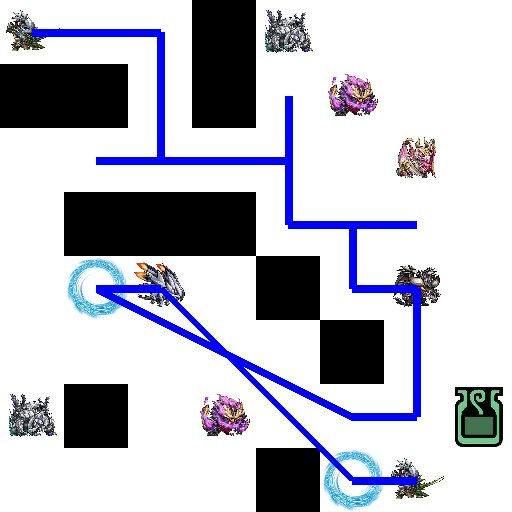

Verbose: Displaying static maze maze_episode_final_38.jpg in Jupyter
Verbose: Starting episode 39/100
Verbose: Resetting environment
Verbose: Episode 39 completed, total reward: 6, steps: 129
Verbose: Generating static maze visualization as maze_episode_final_39.jpg
Verbose: Static maze saved as maze_episode_final_39.jpg in /content


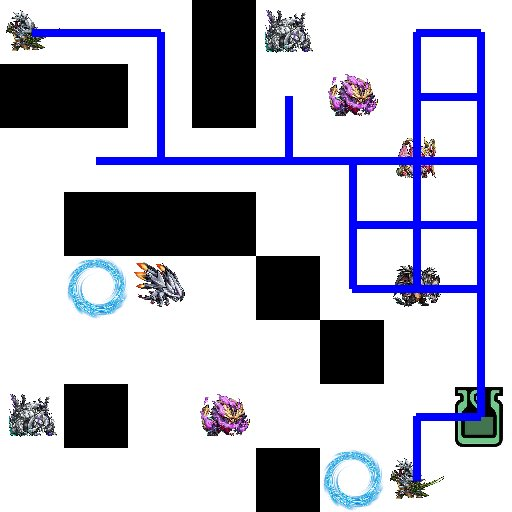

Verbose: Displaying static maze maze_episode_final_39.jpg in Jupyter
Verbose: Starting episode 40/100
Verbose: Resetting environment
Verbose: Episode 40 completed, total reward: 53, steps: 114
Verbose: Generating static maze visualization as maze_episode_final_40.jpg
Verbose: Static maze saved as maze_episode_final_40.jpg in /content


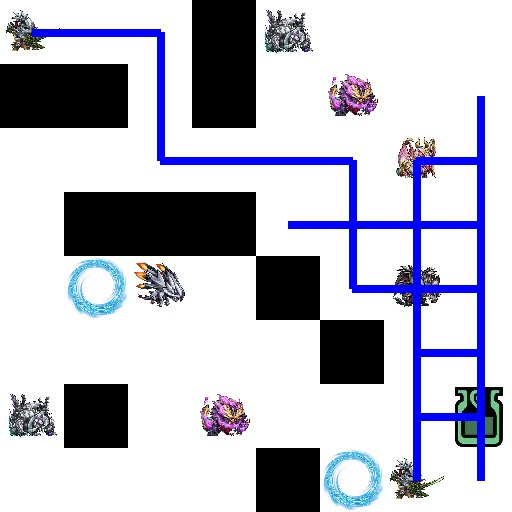

Verbose: Displaying static maze maze_episode_final_40.jpg in Jupyter
Verbose: Starting episode 41/100
Verbose: Resetting environment
Verbose: Episode 41 completed, total reward: 28, steps: 157
Verbose: Generating static maze visualization as maze_episode_final_41.jpg
Verbose: Static maze saved as maze_episode_final_41.jpg in /content


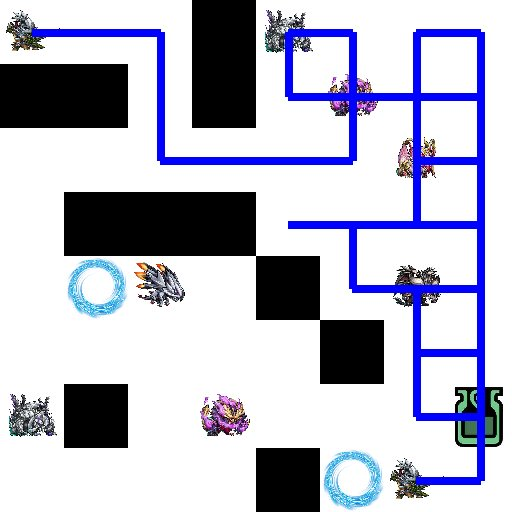

Verbose: Displaying static maze maze_episode_final_41.jpg in Jupyter
Verbose: Starting episode 42/100
Verbose: Resetting environment
Verbose: Episode 42 completed, total reward: 14, steps: 34
Verbose: Generating static maze visualization as maze_episode_final_42.jpg
Verbose: Static maze saved as maze_episode_final_42.jpg in /content


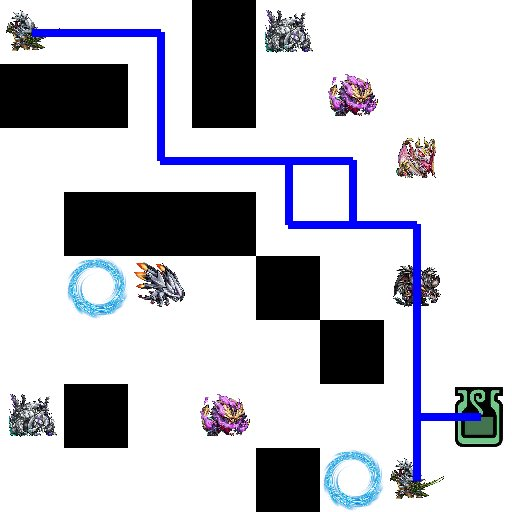

Verbose: Displaying static maze maze_episode_final_42.jpg in Jupyter
Verbose: Starting episode 43/100
Verbose: Resetting environment
Verbose: Episode 43 completed, total reward: 32, steps: 77
Verbose: Generating static maze visualization as maze_episode_final_43.jpg
Verbose: Static maze saved as maze_episode_final_43.jpg in /content


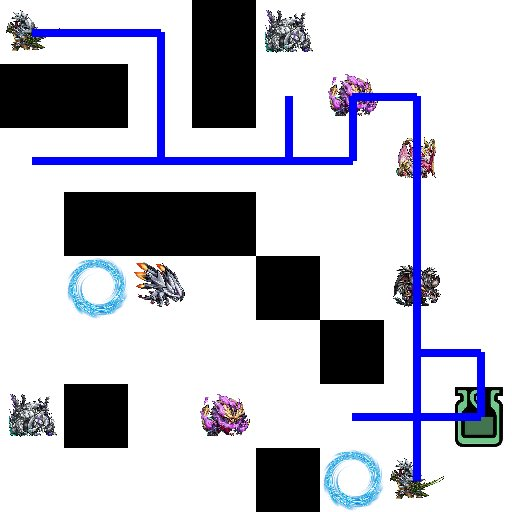

Verbose: Displaying static maze maze_episode_final_43.jpg in Jupyter
Verbose: Starting episode 44/100
Verbose: Resetting environment
Verbose: Episode 44 completed, total reward: 64, steps: 66
Verbose: Generating static maze visualization as maze_episode_final_44.jpg
Verbose: Static maze saved as maze_episode_final_44.jpg in /content


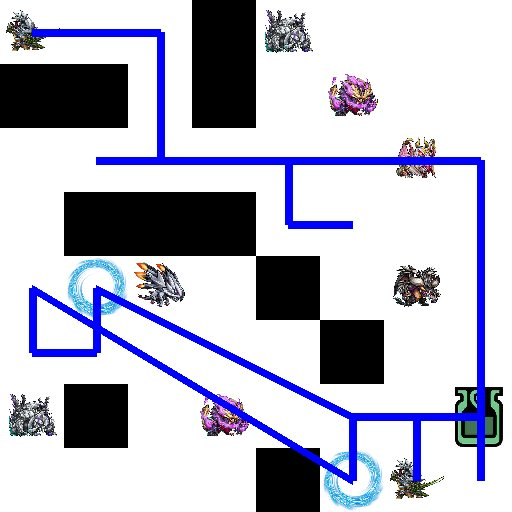

Verbose: Displaying static maze maze_episode_final_44.jpg in Jupyter
Verbose: Starting episode 45/100
Verbose: Resetting environment
Verbose: Episode 45 completed, total reward: 36, steps: 79
Verbose: Generating static maze visualization as maze_episode_final_45.jpg
Verbose: Static maze saved as maze_episode_final_45.jpg in /content


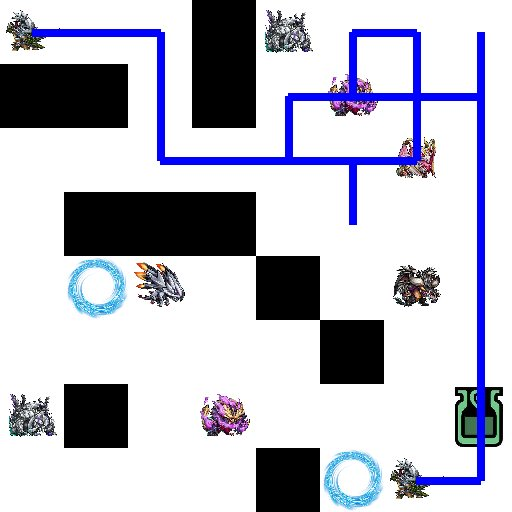

Verbose: Displaying static maze maze_episode_final_45.jpg in Jupyter
Verbose: Starting episode 46/100
Verbose: Resetting environment
Verbose: Episode 46 completed, total reward: 42, steps: 80
Verbose: Generating static maze visualization as maze_episode_final_46.jpg
Verbose: Static maze saved as maze_episode_final_46.jpg in /content


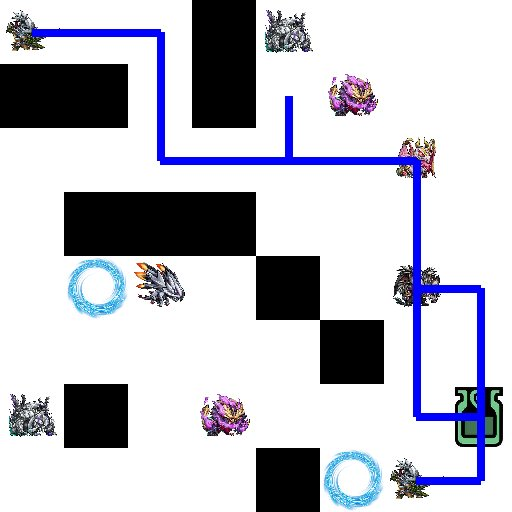

Verbose: Displaying static maze maze_episode_final_46.jpg in Jupyter
Verbose: Starting episode 47/100
Verbose: Resetting environment
Verbose: Episode 47 completed, total reward: 151, steps: 233
Verbose: Generating static maze visualization as maze_episode_final_47.jpg
Verbose: Static maze saved as maze_episode_final_47.jpg in /content


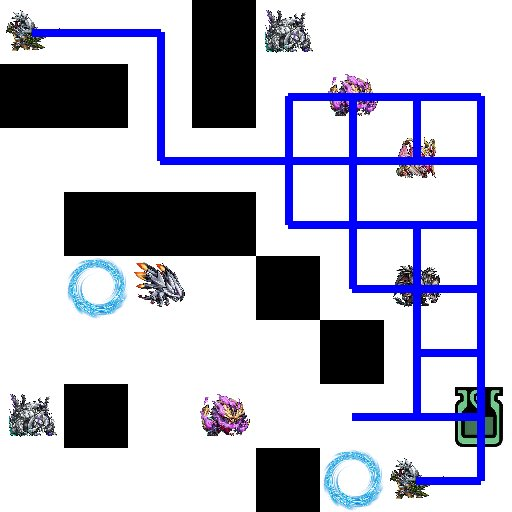

Verbose: Displaying static maze maze_episode_final_47.jpg in Jupyter
Verbose: Starting episode 48/100
Verbose: Resetting environment
Verbose: Episode 48 completed, total reward: 28, steps: 179
Verbose: Generating static maze visualization as maze_episode_final_48.jpg
Verbose: Static maze saved as maze_episode_final_48.jpg in /content


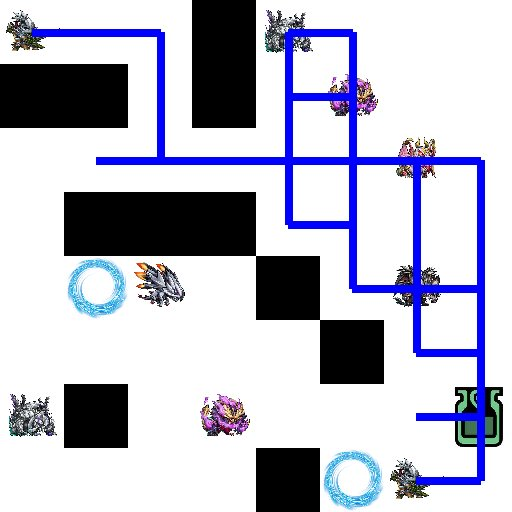

Verbose: Displaying static maze maze_episode_final_48.jpg in Jupyter
Verbose: Starting episode 49/100
Verbose: Resetting environment
Verbose: Episode 49 completed, total reward: 8, steps: 39
Verbose: Generating static maze visualization as maze_episode_final_49.jpg
Verbose: Static maze saved as maze_episode_final_49.jpg in /content


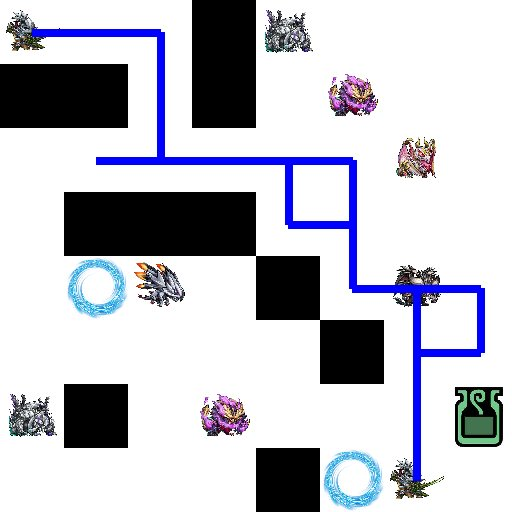

Verbose: Displaying static maze maze_episode_final_49.jpg in Jupyter
Verbose: Starting episode 50/100
Verbose: Resetting environment
Verbose: Episode 50 completed, total reward: 81, steps: 69
Verbose: Generating static maze visualization as maze_episode_final_50.jpg
Verbose: Static maze saved as maze_episode_final_50.jpg in /content


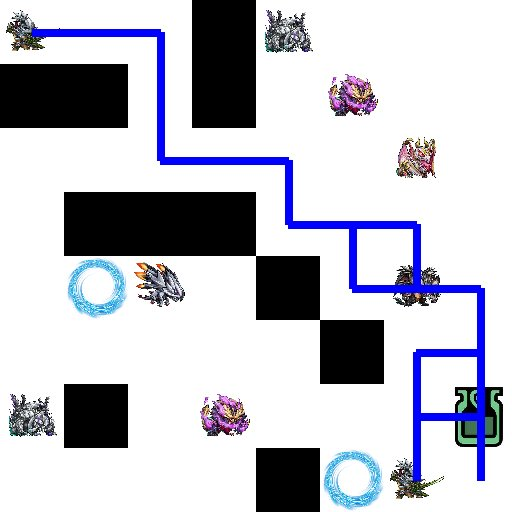

Verbose: Displaying static maze maze_episode_final_50.jpg in Jupyter
Verbose: Starting episode 51/100
Verbose: Resetting environment
Verbose: Episode 51 completed, total reward: 98, steps: 172
Verbose: Generating static maze visualization as maze_episode_final_51.jpg
Verbose: Static maze saved as maze_episode_final_51.jpg in /content


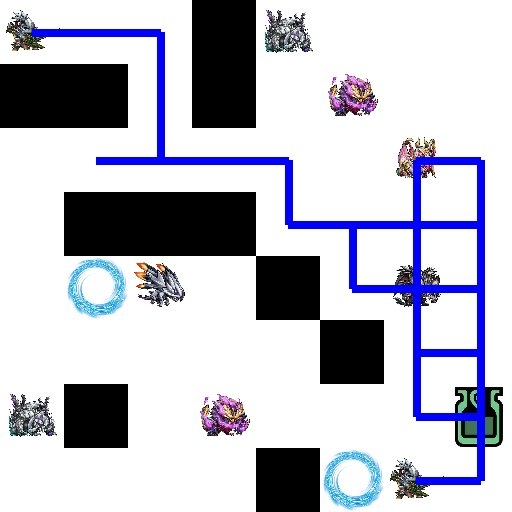

Verbose: Displaying static maze maze_episode_final_51.jpg in Jupyter
Verbose: Starting episode 52/100
Verbose: Resetting environment
Verbose: Episode 52 completed, total reward: 31, steps: 98
Verbose: Generating static maze visualization as maze_episode_final_52.jpg
Verbose: Static maze saved as maze_episode_final_52.jpg in /content


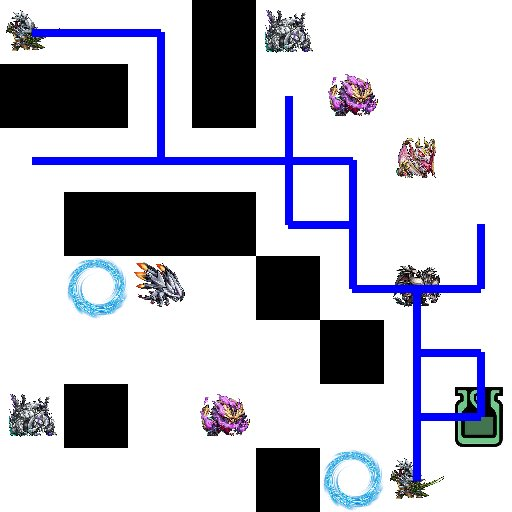

Verbose: Displaying static maze maze_episode_final_52.jpg in Jupyter
Verbose: Starting episode 53/100
Verbose: Resetting environment
Verbose: Episode 53 completed, total reward: 10, steps: 22
Verbose: Generating static maze visualization as maze_episode_final_53.jpg
Verbose: Static maze saved as maze_episode_final_53.jpg in /content


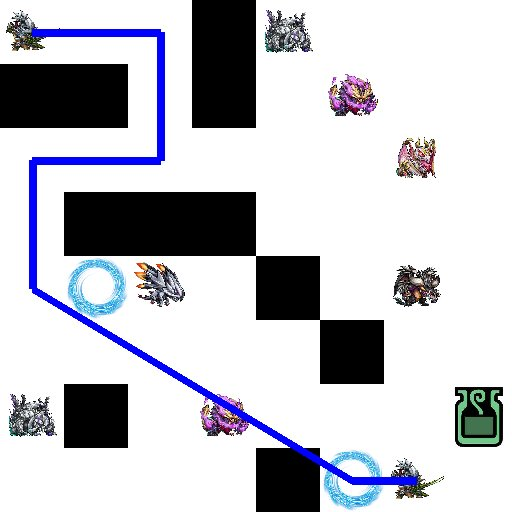

Verbose: Displaying static maze maze_episode_final_53.jpg in Jupyter
Verbose: Starting episode 54/100
Verbose: Resetting environment
Verbose: Episode 54 completed, total reward: 3, steps: 89
Verbose: Generating static maze visualization as maze_episode_final_54.jpg
Verbose: Static maze saved as maze_episode_final_54.jpg in /content


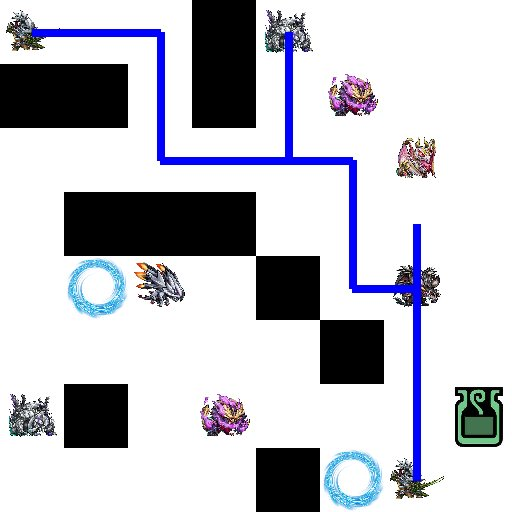

Verbose: Displaying static maze maze_episode_final_54.jpg in Jupyter
Verbose: Starting episode 55/100
Verbose: Resetting environment
Verbose: Episode 55 completed, total reward: 19, steps: 23
Verbose: Generating static maze visualization as maze_episode_final_55.jpg
Verbose: Static maze saved as maze_episode_final_55.jpg in /content


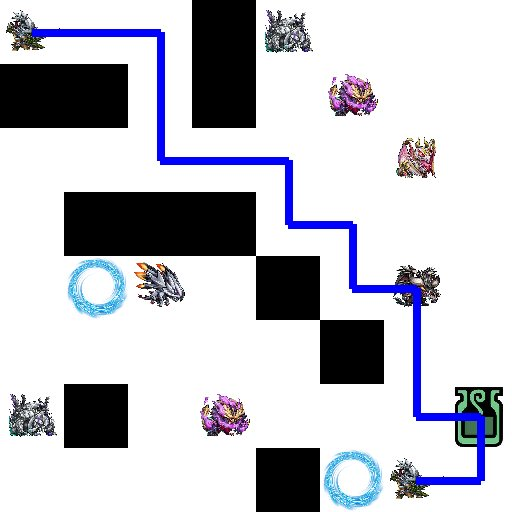

Verbose: Displaying static maze maze_episode_final_55.jpg in Jupyter
Verbose: Starting episode 56/100
Verbose: Resetting environment
Verbose: Episode 56 completed, total reward: 9, steps: 31
Verbose: Generating static maze visualization as maze_episode_final_56.jpg
Verbose: Static maze saved as maze_episode_final_56.jpg in /content


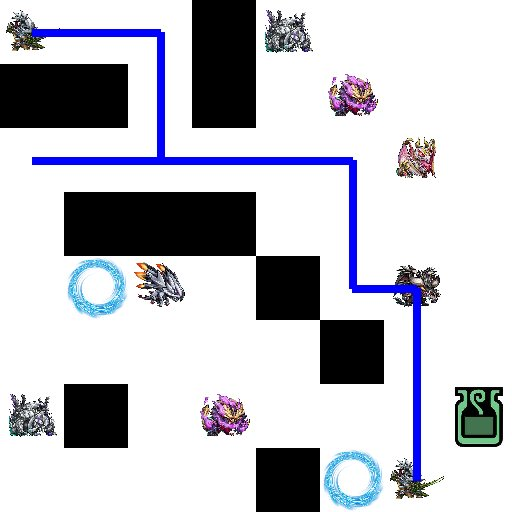

Verbose: Displaying static maze maze_episode_final_56.jpg in Jupyter
Verbose: Starting episode 57/100
Verbose: Resetting environment
Verbose: Episode 57 completed, total reward: 67, steps: 75
Verbose: Generating static maze visualization as maze_episode_final_57.jpg
Verbose: Static maze saved as maze_episode_final_57.jpg in /content


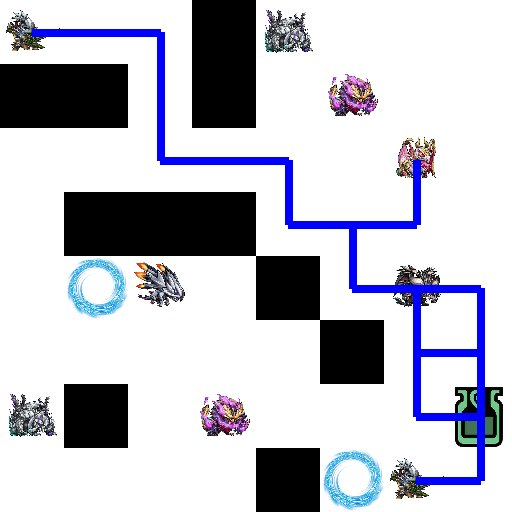

Verbose: Displaying static maze maze_episode_final_57.jpg in Jupyter
Verbose: Starting episode 58/100
Verbose: Resetting environment
Verbose: Episode 58 completed, total reward: 43, steps: 50
Verbose: Generating static maze visualization as maze_episode_final_58.jpg
Verbose: Static maze saved as maze_episode_final_58.jpg in /content


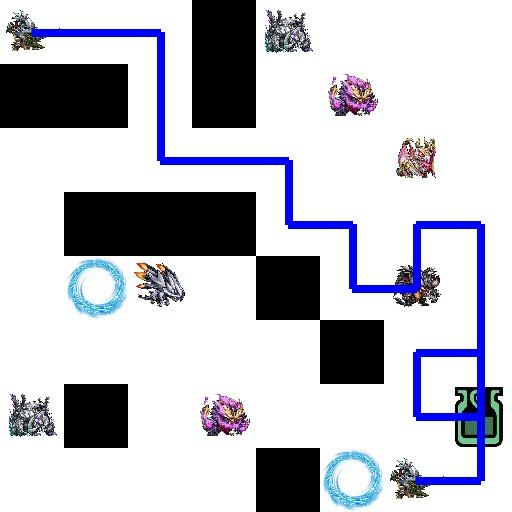

Verbose: Displaying static maze maze_episode_final_58.jpg in Jupyter
Verbose: Starting episode 59/100
Verbose: Resetting environment
Verbose: Episode 59 completed, total reward: 30, steps: 79
Verbose: Generating static maze visualization as maze_episode_final_59.jpg
Verbose: Static maze saved as maze_episode_final_59.jpg in /content


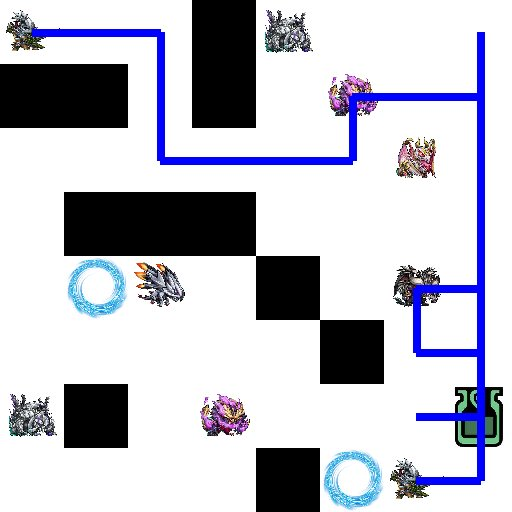

Verbose: Displaying static maze maze_episode_final_59.jpg in Jupyter
Verbose: Starting episode 60/100
Verbose: Resetting environment
Verbose: Episode 60 completed, total reward: 15, steps: 107
Verbose: Generating static maze visualization as maze_episode_final_60.jpg
Verbose: Static maze saved as maze_episode_final_60.jpg in /content


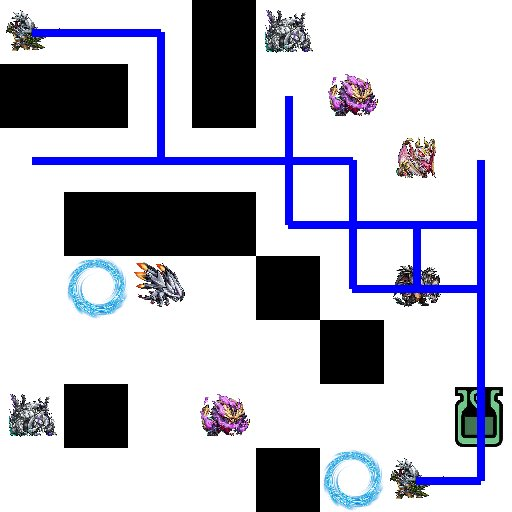

Verbose: Displaying static maze maze_episode_final_60.jpg in Jupyter
Verbose: Starting episode 61/100
Verbose: Resetting environment
Verbose: Episode 61 completed, total reward: 94, steps: 190
Verbose: Generating static maze visualization as maze_episode_final_61.jpg
Verbose: Static maze saved as maze_episode_final_61.jpg in /content


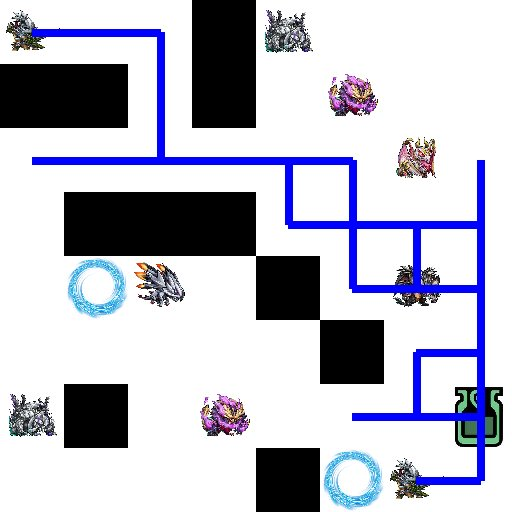

Verbose: Displaying static maze maze_episode_final_61.jpg in Jupyter
Verbose: Starting episode 62/100
Verbose: Resetting environment
Verbose: Episode 62 completed, total reward: 72, steps: 78
Verbose: Generating static maze visualization as maze_episode_final_62.jpg
Verbose: Static maze saved as maze_episode_final_62.jpg in /content


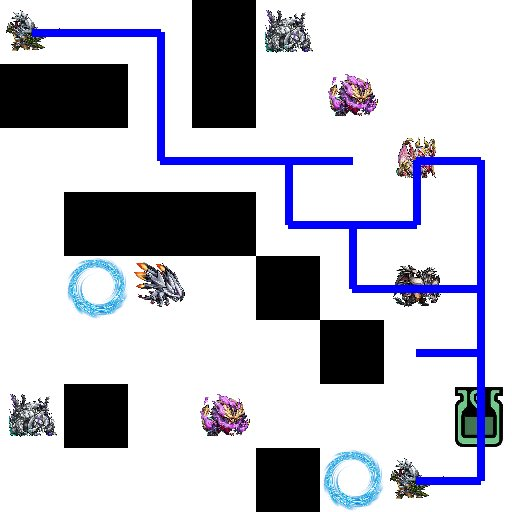

Verbose: Displaying static maze maze_episode_final_62.jpg in Jupyter
Verbose: Starting episode 63/100
Verbose: Resetting environment
Verbose: Episode 63 completed, total reward: 20, steps: 97
Verbose: Generating static maze visualization as maze_episode_final_63.jpg
Verbose: Static maze saved as maze_episode_final_63.jpg in /content


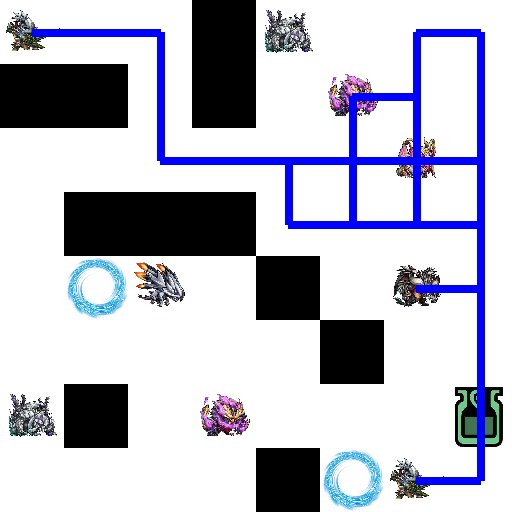

Verbose: Displaying static maze maze_episode_final_63.jpg in Jupyter
Verbose: Starting episode 64/100
Verbose: Resetting environment
Verbose: Episode 64 completed, total reward: 10, steps: 27
Verbose: Generating static maze visualization as maze_episode_final_64.jpg
Verbose: Static maze saved as maze_episode_final_64.jpg in /content


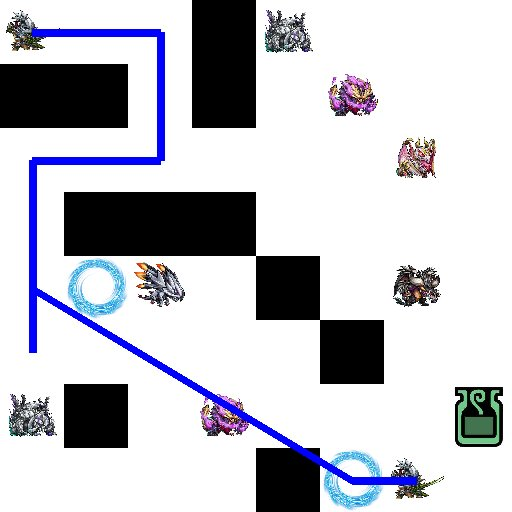

Verbose: Displaying static maze maze_episode_final_64.jpg in Jupyter
Verbose: Starting episode 65/100
Verbose: Resetting environment
Verbose: Episode 65 completed, total reward: 58, steps: 43
Verbose: Generating static maze visualization as maze_episode_final_65.jpg
Verbose: Static maze saved as maze_episode_final_65.jpg in /content


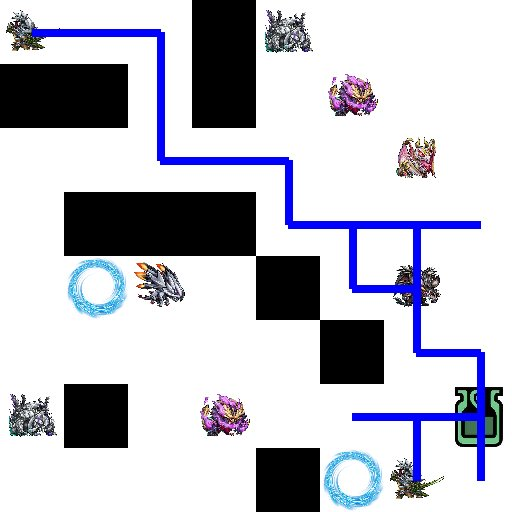

Verbose: Displaying static maze maze_episode_final_65.jpg in Jupyter
Verbose: Starting episode 66/100
Verbose: Resetting environment
Verbose: Episode 66 completed, total reward: 10, steps: 54
Verbose: Generating static maze visualization as maze_episode_final_66.jpg
Verbose: Static maze saved as maze_episode_final_66.jpg in /content


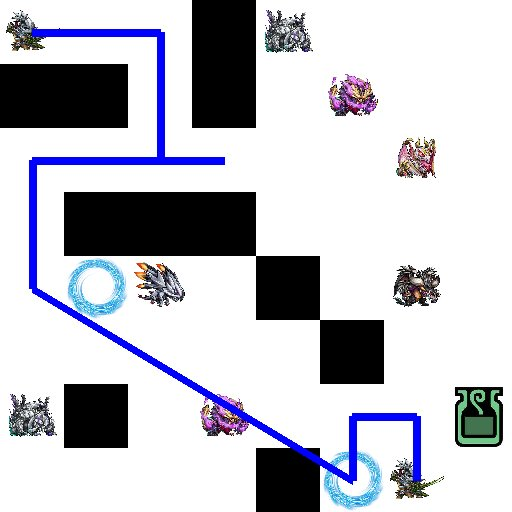

Verbose: Displaying static maze maze_episode_final_66.jpg in Jupyter
Verbose: Starting episode 67/100
Verbose: Resetting environment
Verbose: Episode 67 completed, total reward: 62, steps: 82
Verbose: Generating static maze visualization as maze_episode_final_67.jpg
Verbose: Static maze saved as maze_episode_final_67.jpg in /content


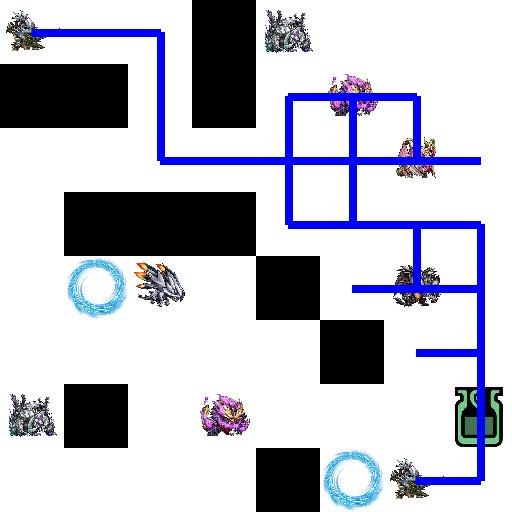

Verbose: Displaying static maze maze_episode_final_67.jpg in Jupyter
Verbose: Starting episode 68/100
Verbose: Resetting environment
Verbose: Episode 68 completed, total reward: 13, steps: 34
Verbose: Generating static maze visualization as maze_episode_final_68.jpg
Verbose: Static maze saved as maze_episode_final_68.jpg in /content


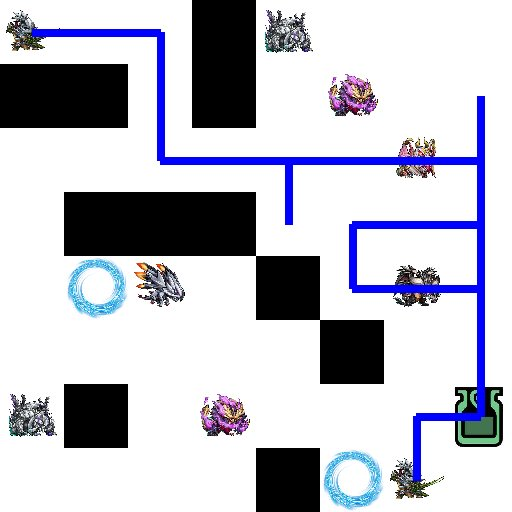

Verbose: Displaying static maze maze_episode_final_68.jpg in Jupyter
Verbose: Starting episode 69/100
Verbose: Resetting environment
Verbose: Episode 69 completed, total reward: 14, steps: 20
Verbose: Generating static maze visualization as maze_episode_final_69.jpg
Verbose: Static maze saved as maze_episode_final_69.jpg in /content


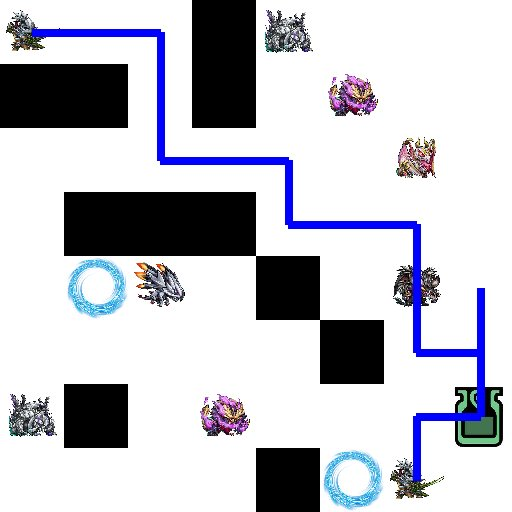

Verbose: Displaying static maze maze_episode_final_69.jpg in Jupyter
Verbose: Starting episode 70/100
Verbose: Resetting environment
Verbose: Episode 70 completed, total reward: 10, steps: 15
Verbose: Generating static maze visualization as maze_episode_final_70.jpg
Verbose: Static maze saved as maze_episode_final_70.jpg in /content


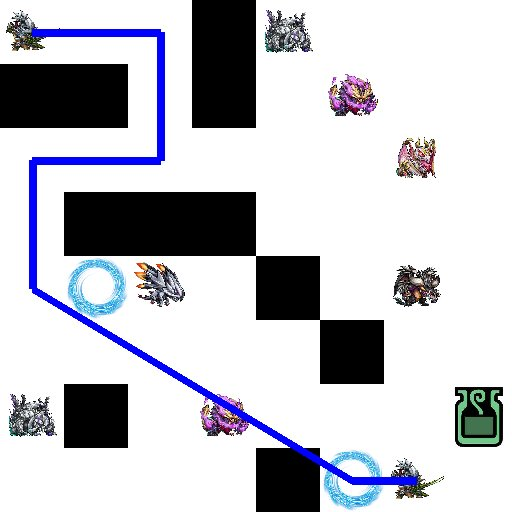

Verbose: Displaying static maze maze_episode_final_70.jpg in Jupyter
Verbose: Starting episode 71/100
Verbose: Resetting environment
Verbose: Episode 71 completed, total reward: 5, steps: 81
Verbose: Generating static maze visualization as maze_episode_final_71.jpg
Verbose: Static maze saved as maze_episode_final_71.jpg in /content


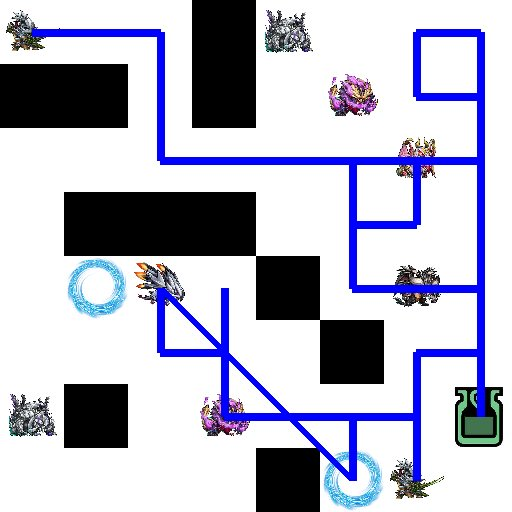

Verbose: Displaying static maze maze_episode_final_71.jpg in Jupyter
Verbose: Starting episode 72/100
Verbose: Resetting environment
Verbose: Episode 72 completed, total reward: 29, steps: 24
Verbose: Generating static maze visualization as maze_episode_final_72.jpg
Verbose: Static maze saved as maze_episode_final_72.jpg in /content


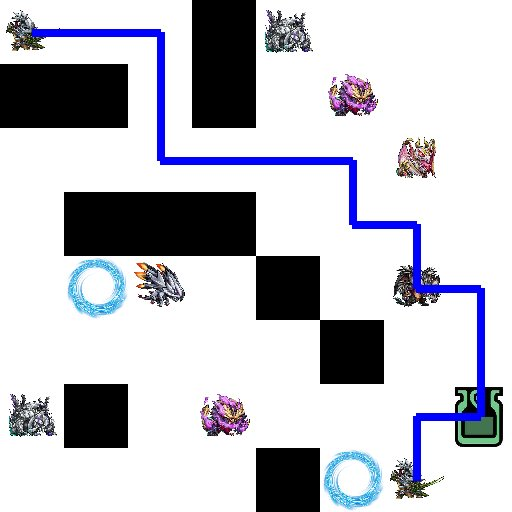

Verbose: Displaying static maze maze_episode_final_72.jpg in Jupyter
Verbose: Starting episode 73/100
Verbose: Resetting environment
Verbose: Episode 73 completed, total reward: 2, steps: 92
Verbose: Generating static maze visualization as maze_episode_final_73.jpg
Verbose: Static maze saved as maze_episode_final_73.jpg in /content


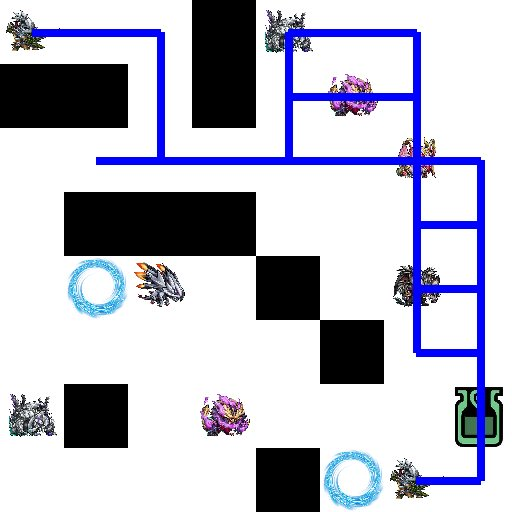

Verbose: Displaying static maze maze_episode_final_73.jpg in Jupyter
Verbose: Starting episode 74/100
Verbose: Resetting environment
Verbose: Episode 74 completed, total reward: 108, steps: 167
Verbose: Generating static maze visualization as maze_episode_final_74.jpg
Verbose: Static maze saved as maze_episode_final_74.jpg in /content


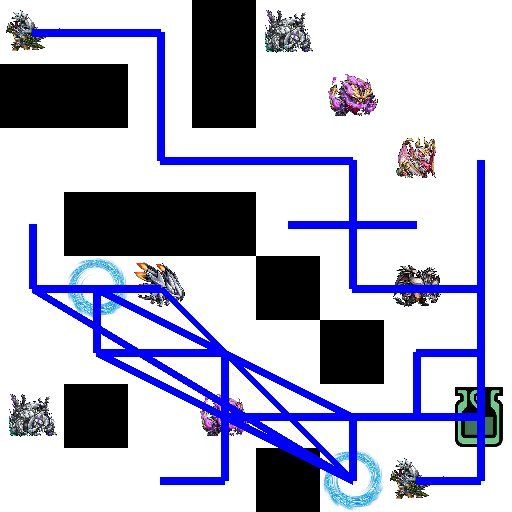

Verbose: Displaying static maze maze_episode_final_74.jpg in Jupyter
Verbose: Starting episode 75/100
Verbose: Resetting environment
Verbose: Episode 75 completed, total reward: 38, steps: 92
Verbose: Generating static maze visualization as maze_episode_final_75.jpg
Verbose: Static maze saved as maze_episode_final_75.jpg in /content


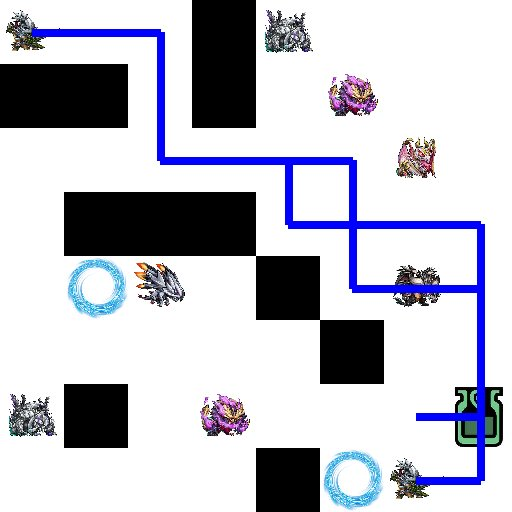

Verbose: Displaying static maze maze_episode_final_75.jpg in Jupyter
Verbose: Starting episode 76/100
Verbose: Resetting environment
Verbose: Episode 76 completed, total reward: 35, steps: 71
Verbose: Generating static maze visualization as maze_episode_final_76.jpg
Verbose: Static maze saved as maze_episode_final_76.jpg in /content


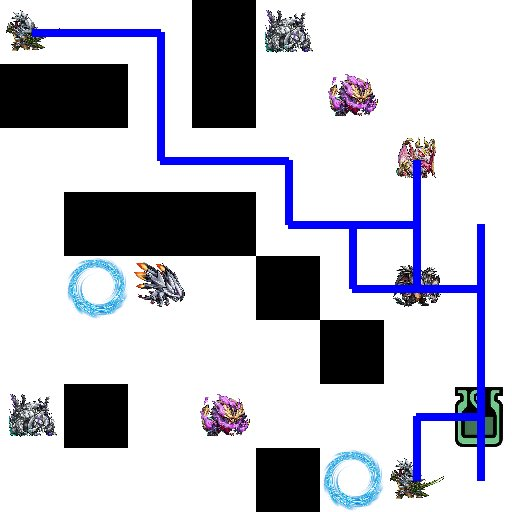

Verbose: Displaying static maze maze_episode_final_76.jpg in Jupyter
Verbose: Starting episode 77/100
Verbose: Resetting environment
Verbose: Episode 77 completed, total reward: 70, steps: 59
Verbose: Generating static maze visualization as maze_episode_final_77.jpg
Verbose: Static maze saved as maze_episode_final_77.jpg in /content


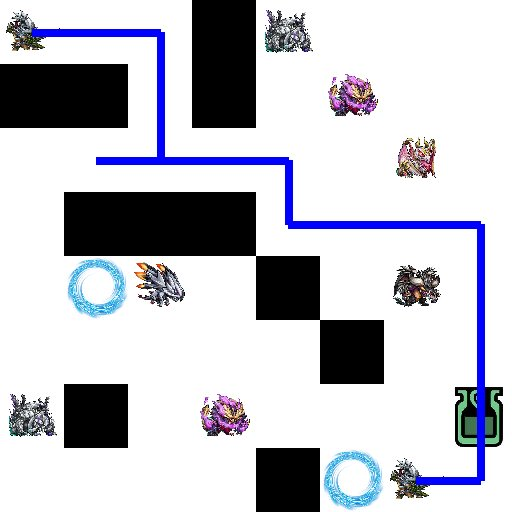

Verbose: Displaying static maze maze_episode_final_77.jpg in Jupyter
Verbose: Starting episode 78/100
Verbose: Resetting environment
Verbose: Episode 78 completed, total reward: 272, steps: 120
Verbose: Generating static maze visualization as maze_episode_final_78.jpg
Verbose: Static maze saved as maze_episode_final_78.jpg in /content


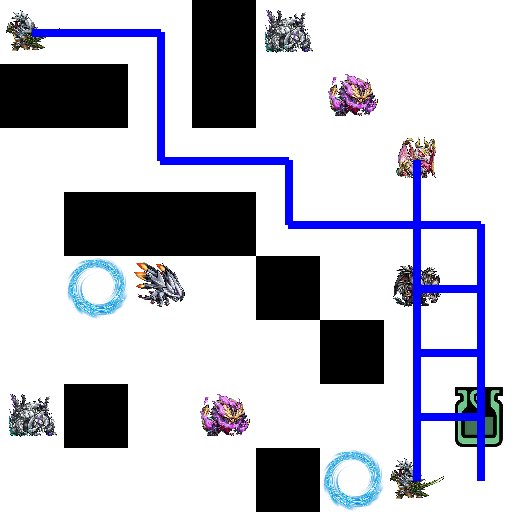

Verbose: Displaying static maze maze_episode_final_78.jpg in Jupyter
Verbose: Starting episode 79/100
Verbose: Resetting environment
Verbose: Episode 79 completed, total reward: 8, steps: 21
Verbose: Generating static maze visualization as maze_episode_final_79.jpg
Verbose: Static maze saved as maze_episode_final_79.jpg in /content


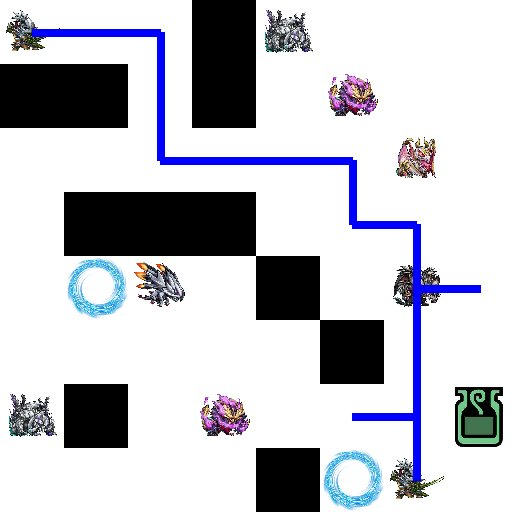

Verbose: Displaying static maze maze_episode_final_79.jpg in Jupyter
Verbose: Starting episode 80/100
Verbose: Resetting environment
Verbose: Episode 80 completed, total reward: 11, steps: 38
Verbose: Generating static maze visualization as maze_episode_final_80.jpg
Verbose: Static maze saved as maze_episode_final_80.jpg in /content


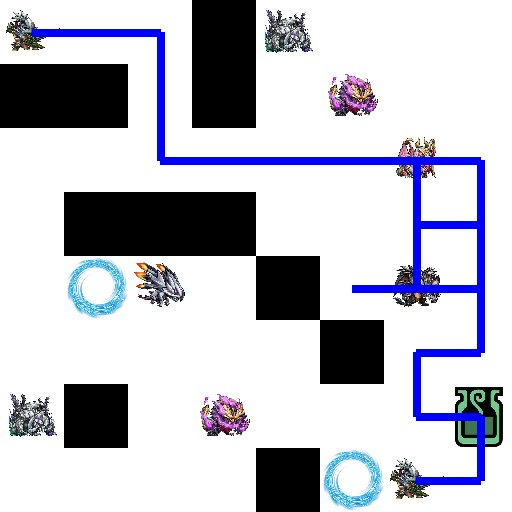

Verbose: Displaying static maze maze_episode_final_80.jpg in Jupyter
Verbose: Starting episode 81/100
Verbose: Resetting environment
Verbose: Episode 81 completed, total reward: 90, steps: 71
Verbose: Generating static maze visualization as maze_episode_final_81.jpg
Verbose: Static maze saved as maze_episode_final_81.jpg in /content


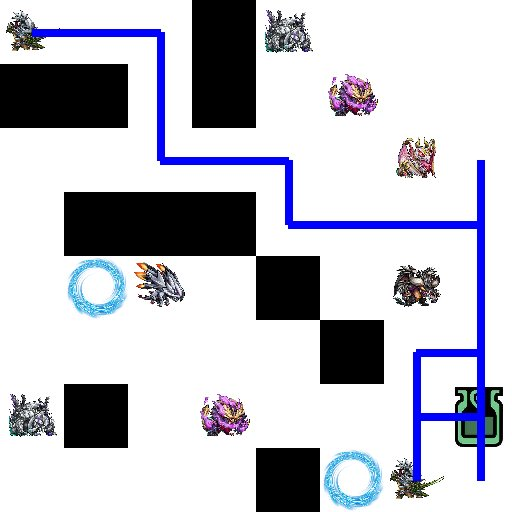

Verbose: Displaying static maze maze_episode_final_81.jpg in Jupyter
Verbose: Starting episode 82/100
Verbose: Resetting environment
Verbose: Episode 82 completed, total reward: 100, steps: 83
Verbose: Generating static maze visualization as maze_episode_final_82.jpg
Verbose: Static maze saved as maze_episode_final_82.jpg in /content


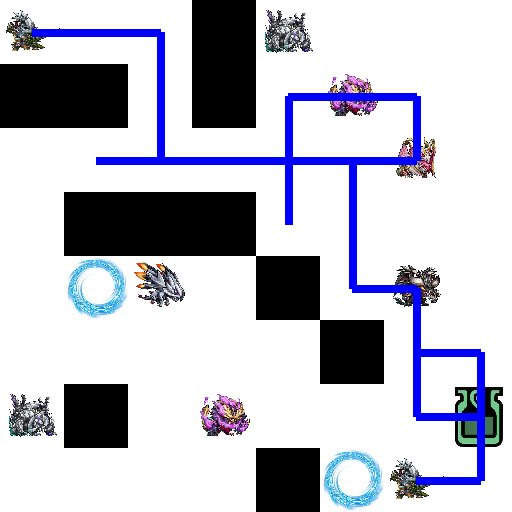

Verbose: Displaying static maze maze_episode_final_82.jpg in Jupyter
Verbose: Starting episode 83/100
Verbose: Resetting environment
Verbose: Episode 83 completed, total reward: 9, steps: 57
Verbose: Generating static maze visualization as maze_episode_final_83.jpg
Verbose: Static maze saved as maze_episode_final_83.jpg in /content


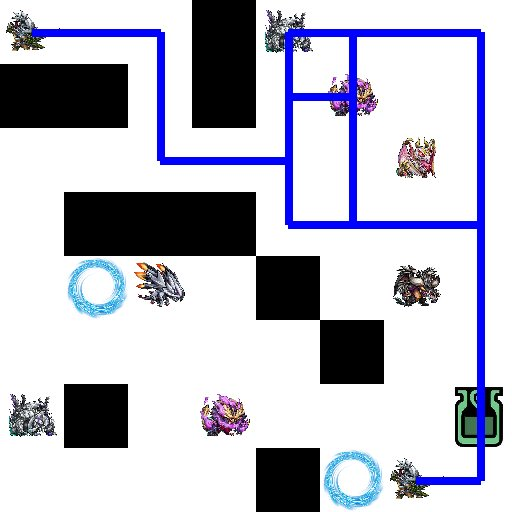

Verbose: Displaying static maze maze_episode_final_83.jpg in Jupyter
Verbose: Starting episode 84/100
Verbose: Resetting environment
Verbose: Episode 84 completed, total reward: 12, steps: 34
Verbose: Generating static maze visualization as maze_episode_final_84.jpg
Verbose: Static maze saved as maze_episode_final_84.jpg in /content


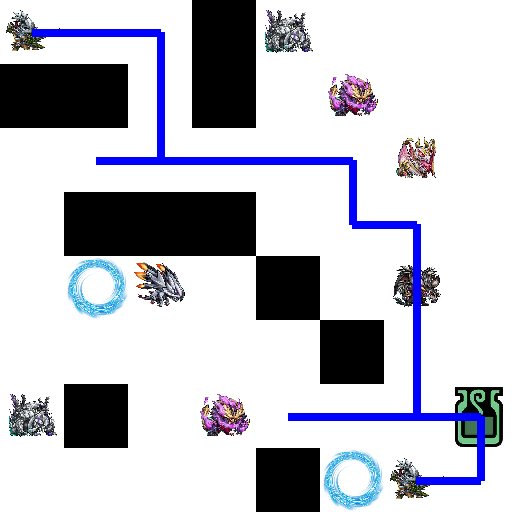

Verbose: Displaying static maze maze_episode_final_84.jpg in Jupyter
Verbose: Starting episode 85/100
Verbose: Resetting environment
Verbose: Episode 85 completed, total reward: 28, steps: 74
Verbose: Generating static maze visualization as maze_episode_final_85.jpg
Verbose: Static maze saved as maze_episode_final_85.jpg in /content


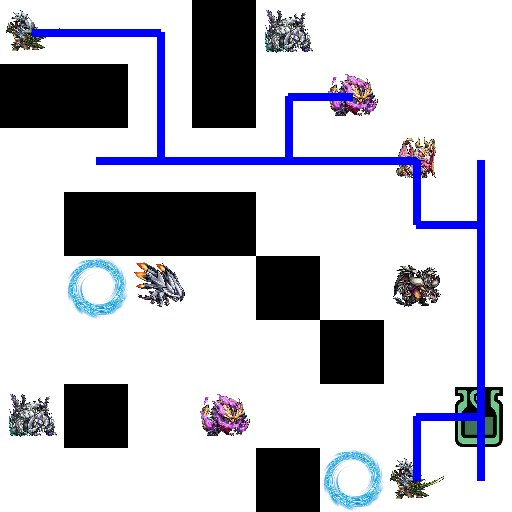

Verbose: Displaying static maze maze_episode_final_85.jpg in Jupyter
Verbose: Starting episode 86/100
Verbose: Resetting environment
Verbose: Episode 86 completed, total reward: 13, steps: 32
Verbose: Generating static maze visualization as maze_episode_final_86.jpg
Verbose: Static maze saved as maze_episode_final_86.jpg in /content


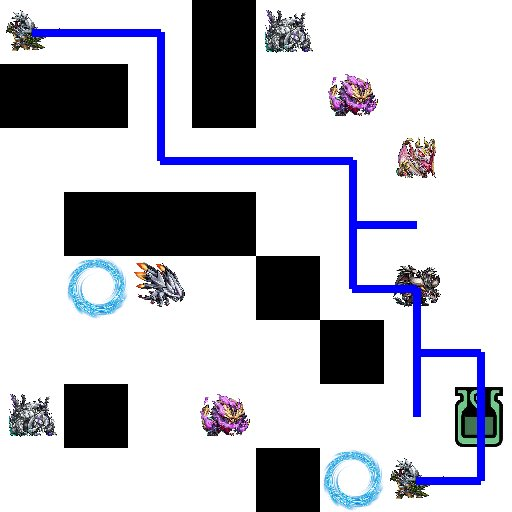

Verbose: Displaying static maze maze_episode_final_86.jpg in Jupyter
Verbose: Starting episode 87/100
Verbose: Resetting environment
Verbose: Episode 87 completed, total reward: 56, steps: 58
Verbose: Generating static maze visualization as maze_episode_final_87.jpg
Verbose: Static maze saved as maze_episode_final_87.jpg in /content


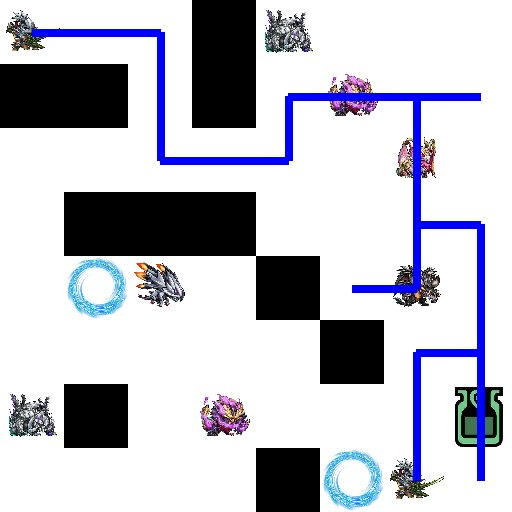

Verbose: Displaying static maze maze_episode_final_87.jpg in Jupyter
Verbose: Starting episode 88/100
Verbose: Resetting environment
Verbose: Episode 88 completed, total reward: 34, steps: 63
Verbose: Generating static maze visualization as maze_episode_final_88.jpg
Verbose: Static maze saved as maze_episode_final_88.jpg in /content


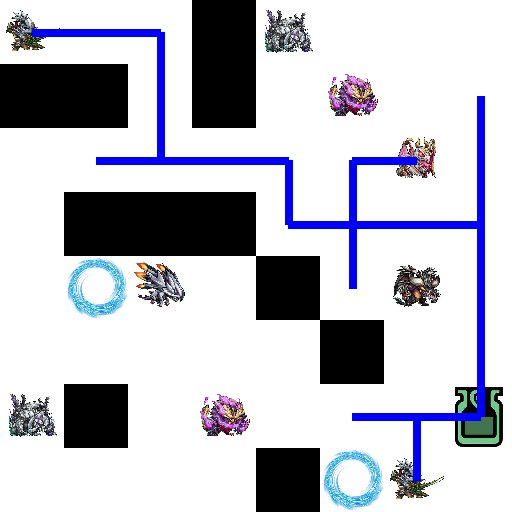

Verbose: Displaying static maze maze_episode_final_88.jpg in Jupyter
Verbose: Starting episode 89/100
Verbose: Resetting environment
Verbose: Episode 89 completed, total reward: 58, steps: 57
Verbose: Generating static maze visualization as maze_episode_final_89.jpg
Verbose: Static maze saved as maze_episode_final_89.jpg in /content


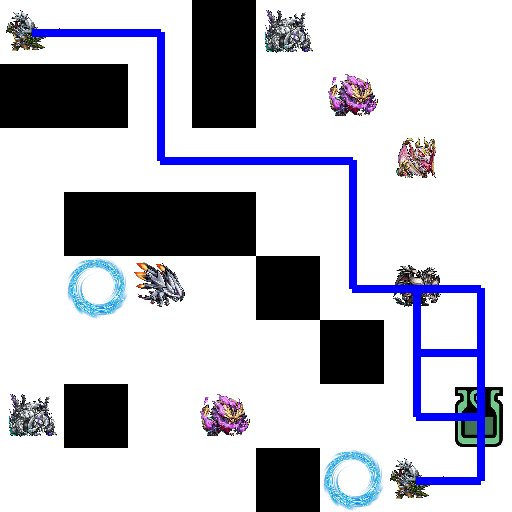

Verbose: Displaying static maze maze_episode_final_89.jpg in Jupyter
Verbose: Starting episode 90/100
Verbose: Resetting environment
Verbose: Episode 90 completed, total reward: 26, steps: 67
Verbose: Generating static maze visualization as maze_episode_final_90.jpg
Verbose: Static maze saved as maze_episode_final_90.jpg in /content


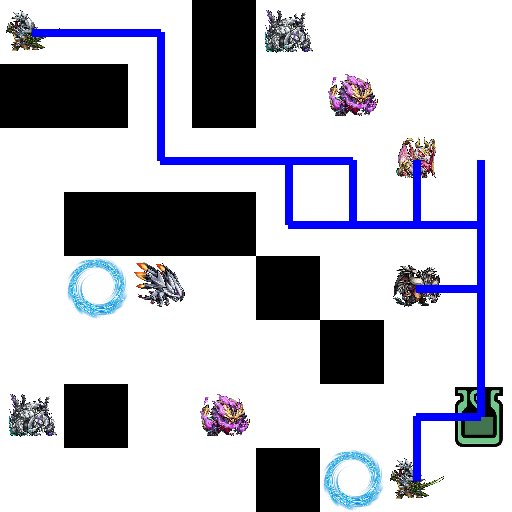

Verbose: Displaying static maze maze_episode_final_90.jpg in Jupyter
Verbose: Starting episode 91/100
Verbose: Resetting environment
Verbose: Episode 91 completed, total reward: 23, steps: 80
Verbose: Generating static maze visualization as maze_episode_final_91.jpg
Verbose: Static maze saved as maze_episode_final_91.jpg in /content


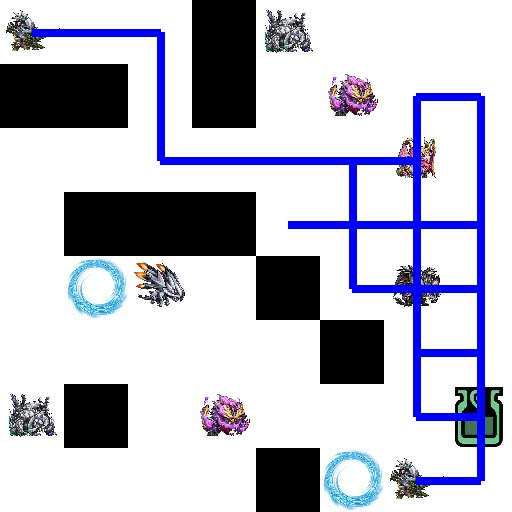

Verbose: Displaying static maze maze_episode_final_91.jpg in Jupyter
Verbose: Starting episode 92/100
Verbose: Resetting environment
Verbose: Episode 92 completed, total reward: 23, steps: 49
Verbose: Generating static maze visualization as maze_episode_final_92.jpg
Verbose: Static maze saved as maze_episode_final_92.jpg in /content


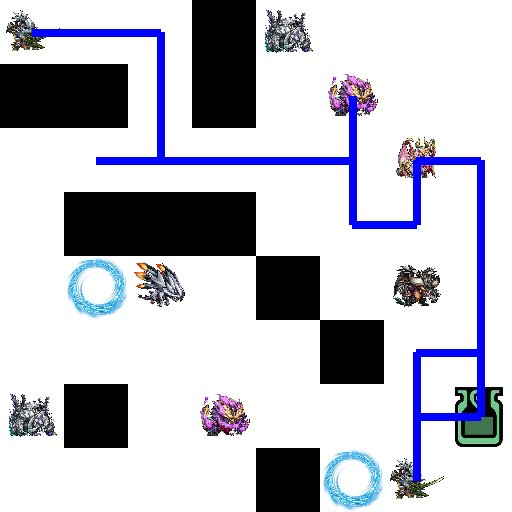

Verbose: Displaying static maze maze_episode_final_92.jpg in Jupyter
Verbose: Starting episode 93/100
Verbose: Resetting environment
Verbose: Episode 93 completed, total reward: 135, steps: 79
Verbose: Generating static maze visualization as maze_episode_final_93.jpg
Verbose: Static maze saved as maze_episode_final_93.jpg in /content


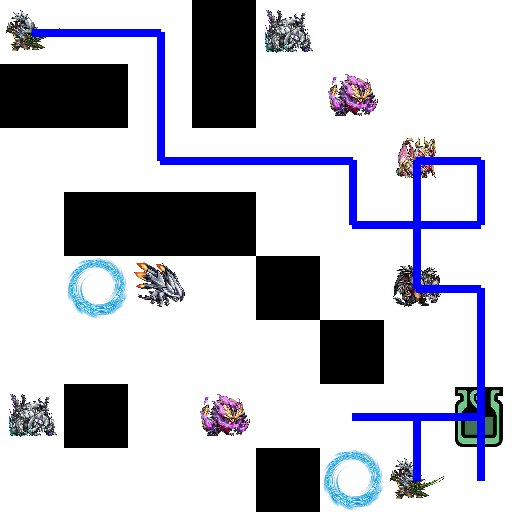

Verbose: Displaying static maze maze_episode_final_93.jpg in Jupyter
Verbose: Starting episode 94/100
Verbose: Resetting environment
Verbose: Episode 94 completed, total reward: 165, steps: 111
Verbose: Generating static maze visualization as maze_episode_final_94.jpg
Verbose: Static maze saved as maze_episode_final_94.jpg in /content


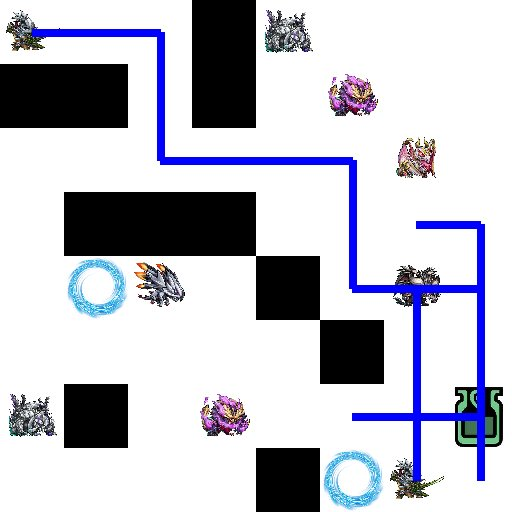

Verbose: Displaying static maze maze_episode_final_94.jpg in Jupyter
Verbose: Starting episode 95/100
Verbose: Resetting environment
Verbose: Episode 95 completed, total reward: 47, steps: 85
Verbose: Generating static maze visualization as maze_episode_final_95.jpg
Verbose: Static maze saved as maze_episode_final_95.jpg in /content


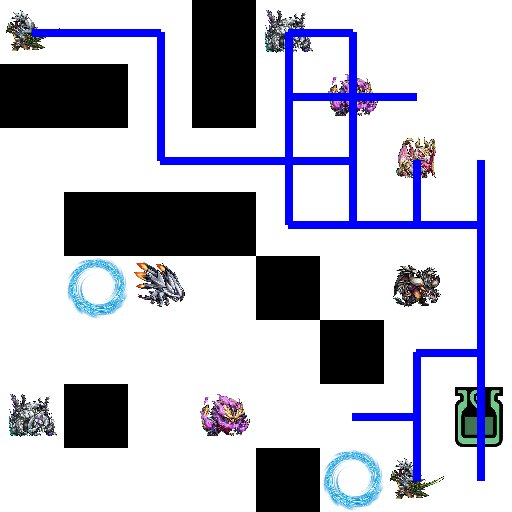

Verbose: Displaying static maze maze_episode_final_95.jpg in Jupyter
Verbose: Starting episode 96/100
Verbose: Resetting environment
Verbose: Episode 96 completed, total reward: 19, steps: 30
Verbose: Generating static maze visualization as maze_episode_final_96.jpg
Verbose: Static maze saved as maze_episode_final_96.jpg in /content


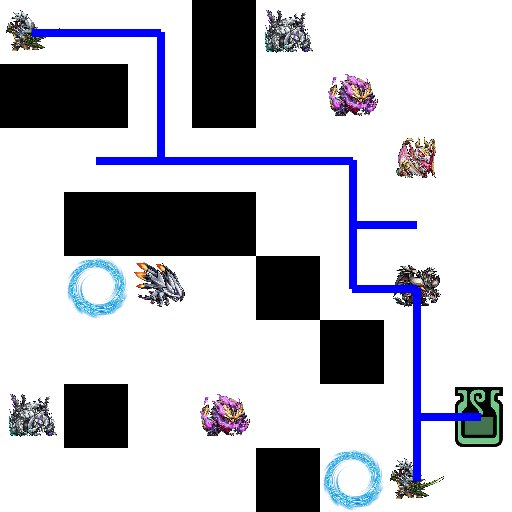

Verbose: Displaying static maze maze_episode_final_96.jpg in Jupyter
Verbose: Starting episode 97/100
Verbose: Resetting environment
Verbose: Episode 97 completed, total reward: 33, steps: 53
Verbose: Generating static maze visualization as maze_episode_final_97.jpg
Verbose: Static maze saved as maze_episode_final_97.jpg in /content


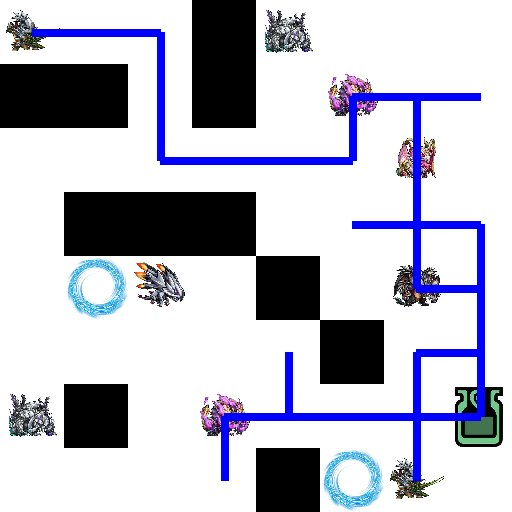

Verbose: Displaying static maze maze_episode_final_97.jpg in Jupyter
Verbose: Starting episode 98/100
Verbose: Resetting environment
Verbose: Episode 98 completed, total reward: 19, steps: 57
Verbose: Generating static maze visualization as maze_episode_final_98.jpg
Verbose: Static maze saved as maze_episode_final_98.jpg in /content


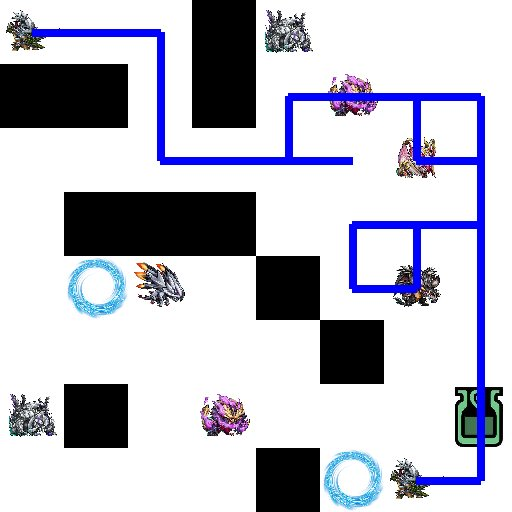

Verbose: Displaying static maze maze_episode_final_98.jpg in Jupyter
Verbose: Starting episode 99/100
Verbose: Resetting environment
Verbose: Episode 99 completed, total reward: 16, steps: 54
Verbose: Generating static maze visualization as maze_episode_final_99.jpg
Verbose: Static maze saved as maze_episode_final_99.jpg in /content


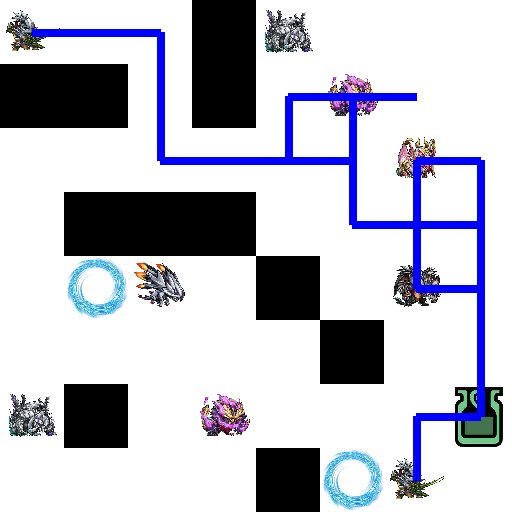

Verbose: Displaying static maze maze_episode_final_99.jpg in Jupyter
Verbose: Starting episode 100/100
Verbose: Resetting environment
Verbose: Episode 100 completed, total reward: 50, steps: 48
Verbose: Generating static maze visualization as maze_episode_final_100.jpg
Verbose: Static maze saved as maze_episode_final_100.jpg in /content


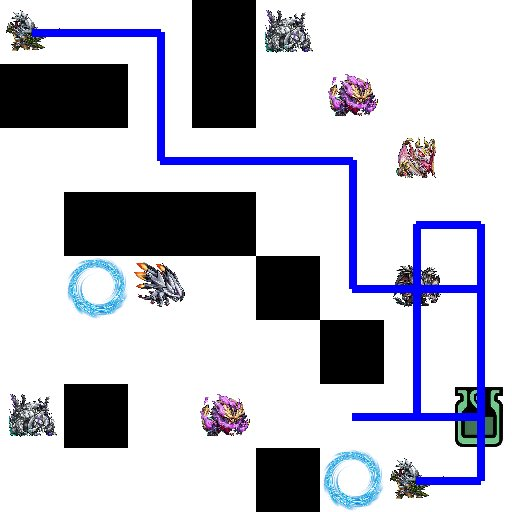

Verbose: Displaying static maze maze_episode_final_100.jpg in Jupyter
Verbose: Training completed
Verbose: Starting manual testing mode
Verbose: Resetting environment
Manual testing started. Choose actions:
Verbose: Generating static maze visualization as maze_manual_start.jpg
Verbose: Static maze saved as maze_manual_start.jpg in /content


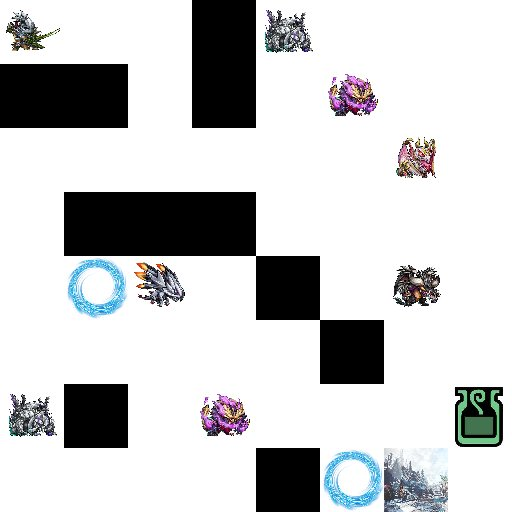

Verbose: Displaying static maze maze_manual_start.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
1
Verbose: Moved to state 1, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_1.jpg
Verbose: Static maze saved as maze_manual_step_1.jpg in /content


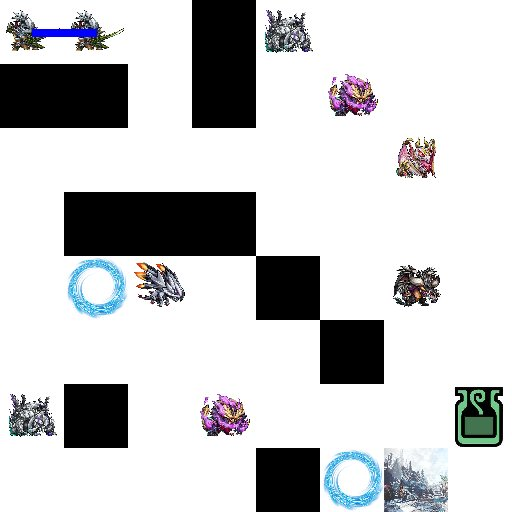

Verbose: Displaying static maze maze_manual_step_1.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
1
Verbose: Moved to state 2, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_2.jpg
Verbose: Static maze saved as maze_manual_step_2.jpg in /content


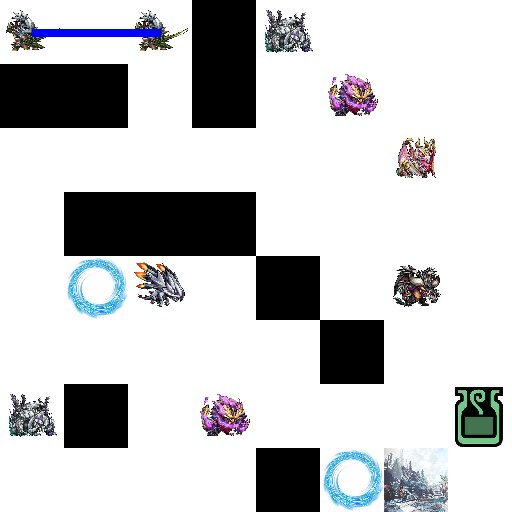

Verbose: Displaying static maze maze_manual_step_2.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
3
Verbose: Moved to state 10, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_3.jpg
Verbose: Static maze saved as maze_manual_step_3.jpg in /content


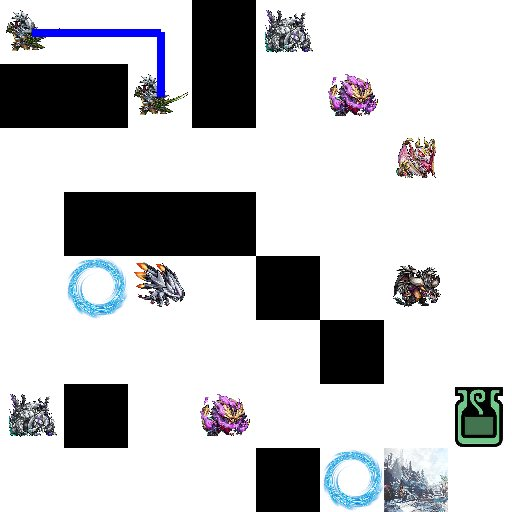

Verbose: Displaying static maze maze_manual_step_3.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
3
Verbose: Moved to state 18, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_4.jpg
Verbose: Static maze saved as maze_manual_step_4.jpg in /content


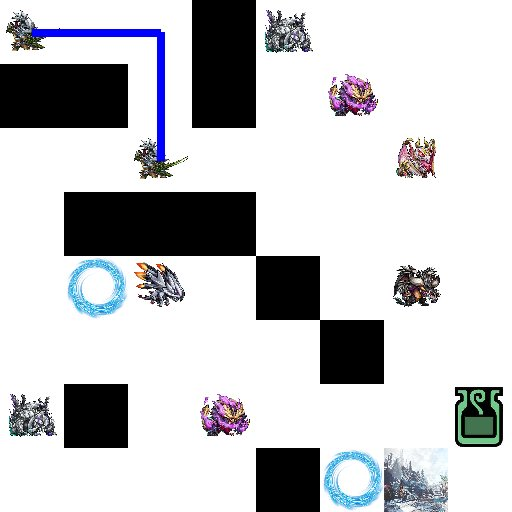

Verbose: Displaying static maze maze_manual_step_4.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
1
Verbose: Moved to state 19, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_5.jpg
Verbose: Static maze saved as maze_manual_step_5.jpg in /content


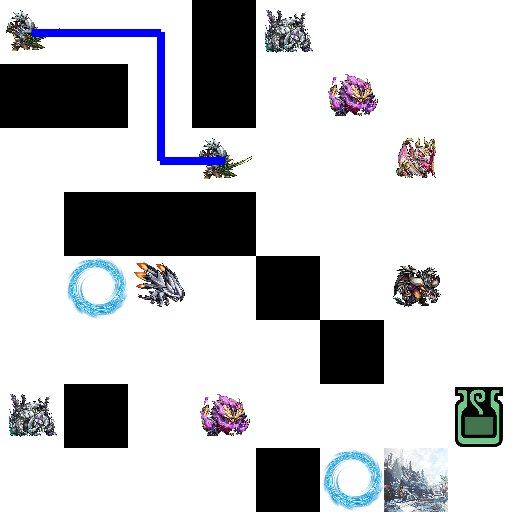


Verbose: Displaying static maze maze_manual_step_5.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):

Verbose: Invalid input. Please enter an integer.
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
Verbose: Invalid input. Please enter an integer.
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
1
Verbose: Moved to state 20, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_6.jpg
Verbose: Static maze saved as maze_manual_step_6.jpg in /content


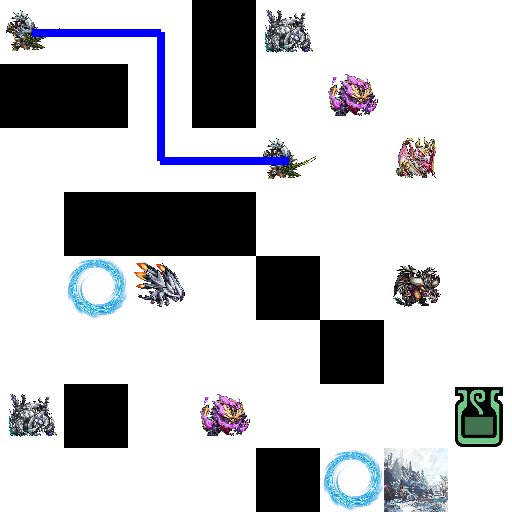

Verbose: Displaying static maze maze_manual_step_6.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
1
Verbose: Moved to state 21, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_7.jpg
Verbose: Static maze saved as maze_manual_step_7.jpg in /content


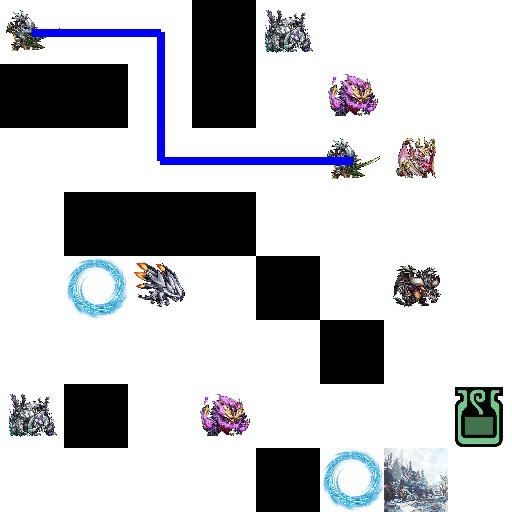

Verbose: Displaying static maze maze_manual_step_7.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
1
Verbose: Moved to state 22, reward: -1, done: False
Verbose: Generating static maze visualization as maze_manual_step_8.jpg
Verbose: Static maze saved as maze_manual_step_8.jpg in /content


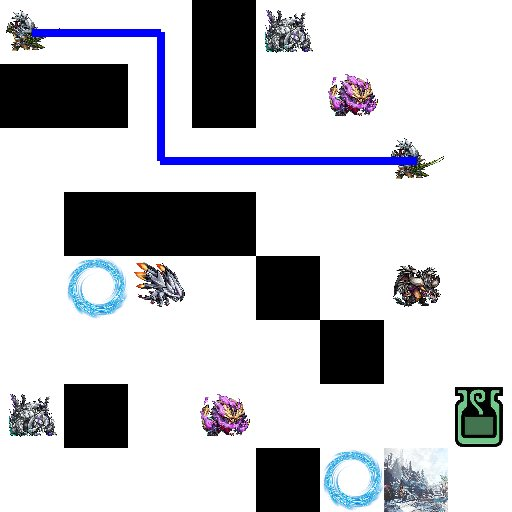

Verbose: Displaying static maze maze_manual_step_8.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
1
Verbose: Moved to state 23, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_9.jpg
Verbose: Static maze saved as maze_manual_step_9.jpg in /content


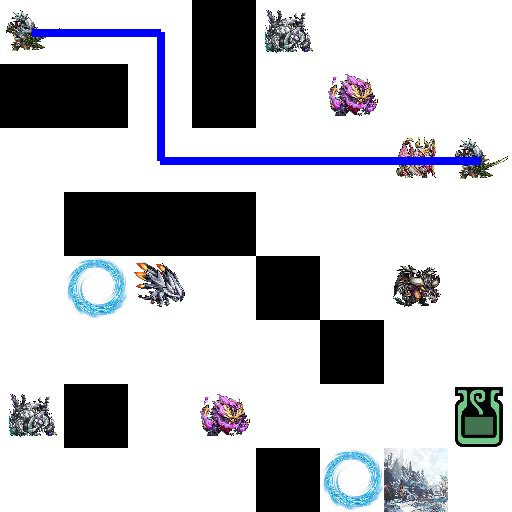

Verbose: Displaying static maze maze_manual_step_9.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
3
Verbose: Moved to state 31, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_10.jpg
Verbose: Static maze saved as maze_manual_step_10.jpg in /content


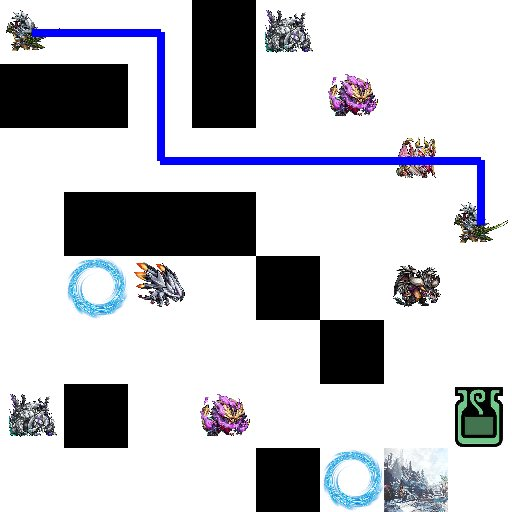

Verbose: Displaying static maze maze_manual_step_10.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
3
Verbose: Moved to state 39, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_11.jpg
Verbose: Static maze saved as maze_manual_step_11.jpg in /content


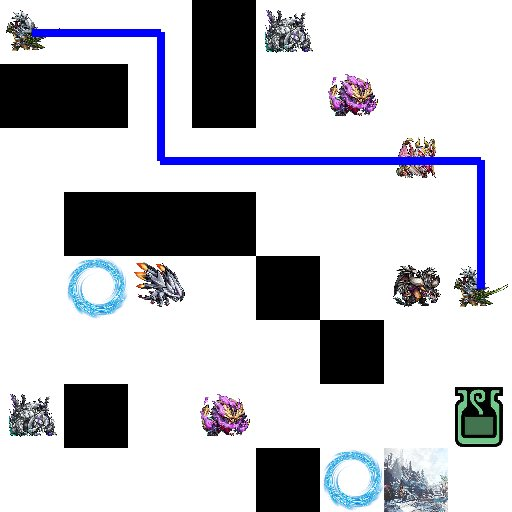

Verbose: Displaying static maze maze_manual_step_11.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
3
Verbose: Moved to state 47, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_12.jpg
Verbose: Static maze saved as maze_manual_step_12.jpg in /content


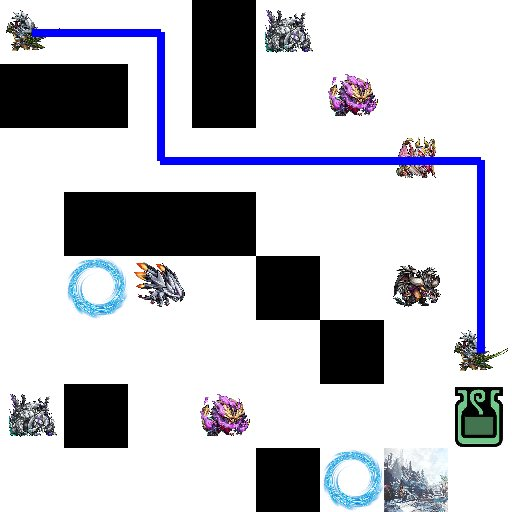

Verbose: Displaying static maze maze_manual_step_12.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
3
Verbose: Moved to state 55, reward: 5, done: False
Verbose: Generating static maze visualization as maze_manual_step_13.jpg
Verbose: Static maze saved as maze_manual_step_13.jpg in /content


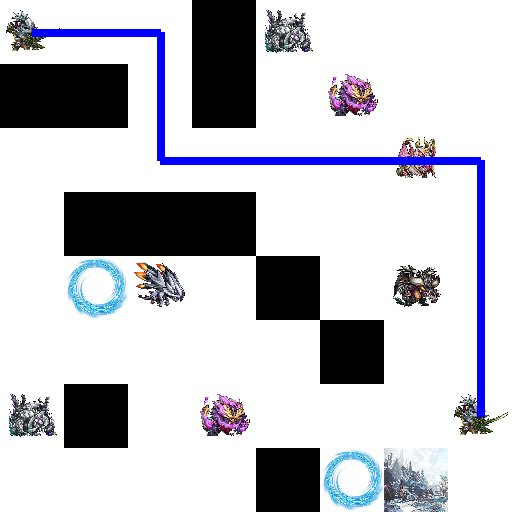

Verbose: Displaying static maze maze_manual_step_13.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
0
Verbose: Moved to state 54, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_14.jpg
Verbose: Static maze saved as maze_manual_step_14.jpg in /content


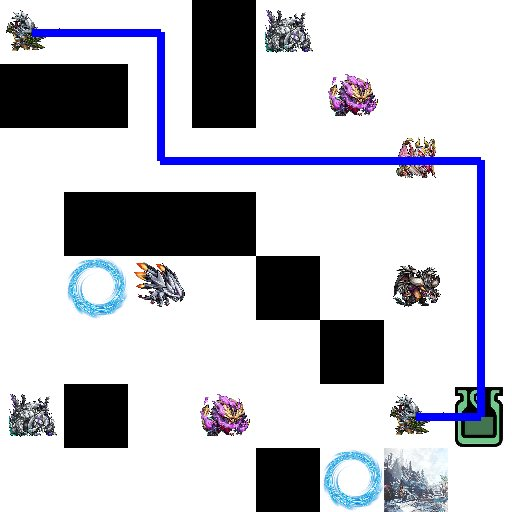

Verbose: Displaying static maze maze_manual_step_14.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
0
Verbose: Moved to state 53, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_15.jpg
Verbose: Static maze saved as maze_manual_step_15.jpg in /content


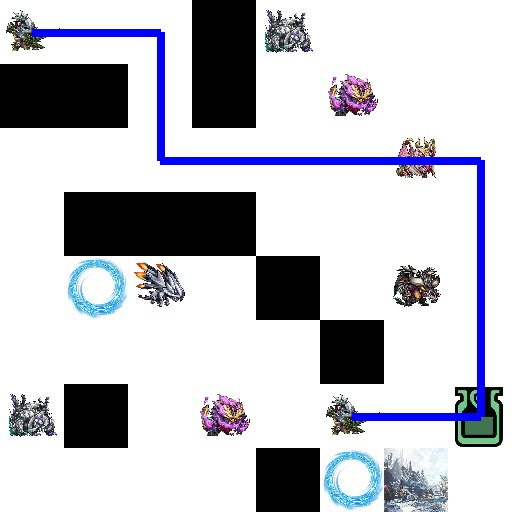

Verbose: Displaying static maze maze_manual_step_15.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
0
Verbose: Moved to state 52, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_16.jpg
Verbose: Static maze saved as maze_manual_step_16.jpg in /content


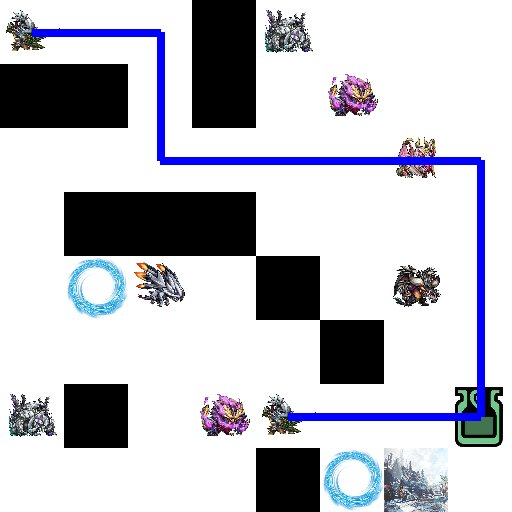

Verbose: Displaying static maze maze_manual_step_16.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
0
Verbose: Moved to state 51, reward: -1, done: False
Verbose: Generating static maze visualization as maze_manual_step_17.jpg
Verbose: Static maze saved as maze_manual_step_17.jpg in /content


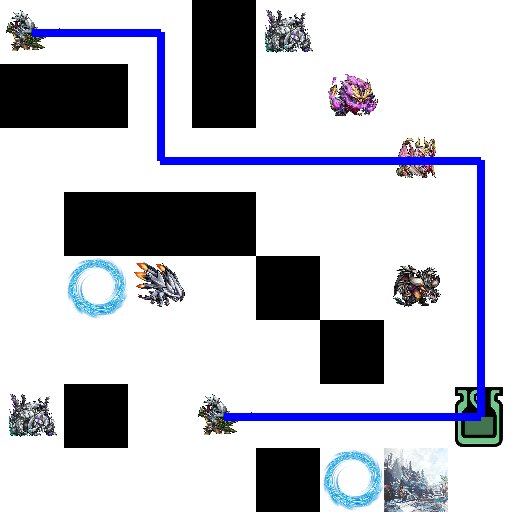

Verbose: Displaying static maze maze_manual_step_17.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
0
Verbose: Moved to state 50, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_18.jpg
Verbose: Static maze saved as maze_manual_step_18.jpg in /content


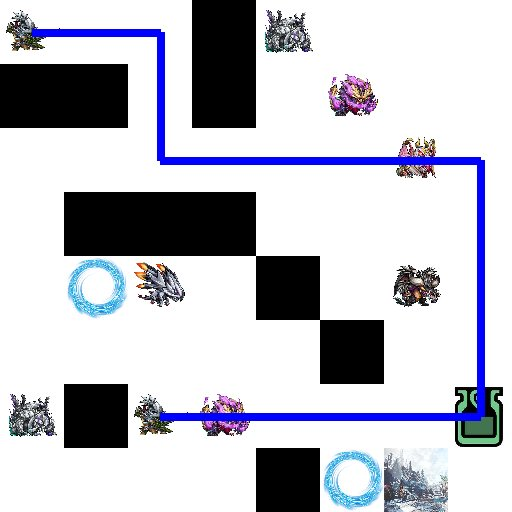

Verbose: Displaying static maze maze_manual_step_18.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
2
Verbose: Moved to state 42, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_19.jpg
Verbose: Static maze saved as maze_manual_step_19.jpg in /content


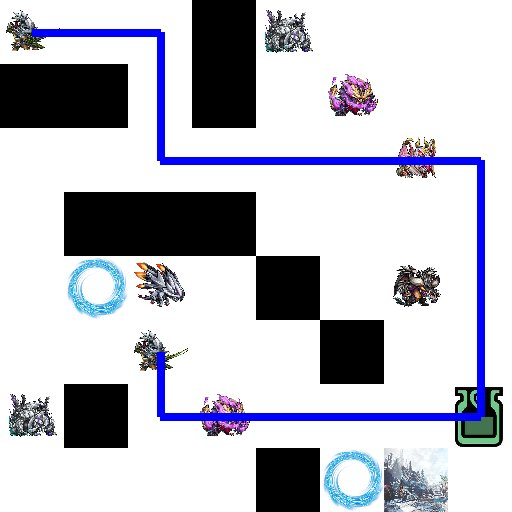

Verbose: Displaying static maze maze_manual_step_19.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
2
Verbose: Moved to state 34, reward: -1, done: False
Verbose: Generating static maze visualization as maze_manual_step_20.jpg
Verbose: Static maze saved as maze_manual_step_20.jpg in /content


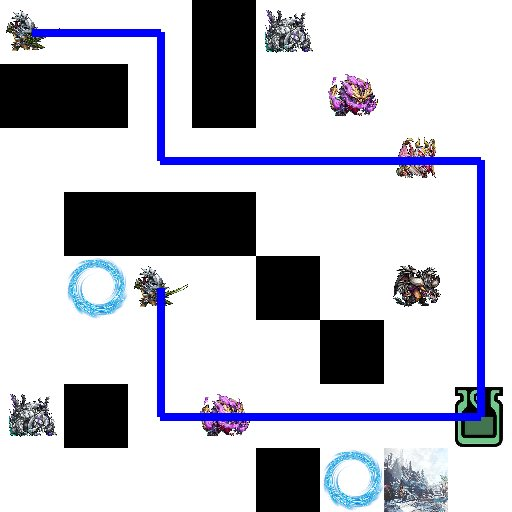

Verbose: Displaying static maze maze_manual_step_20.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
0
Verbose: Moved to state 61, reward: 0, done: False
Verbose: Generating static maze visualization as maze_manual_step_21.jpg
Verbose: Static maze saved as maze_manual_step_21.jpg in /content


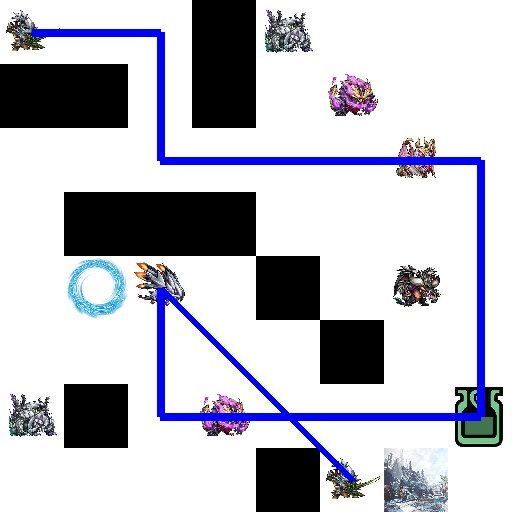

Verbose: Displaying static maze maze_manual_step_21.jpg in Jupyter
Enter action (0=Left, 1=Right, 2=Up, 3=Down, or -1 to exit):
1
Verbose: Moved to state 62, reward: 10, done: True
Verbose: Generating static maze visualization as maze_manual_step_22.jpg
Verbose: Static maze saved as maze_manual_step_22.jpg in /content


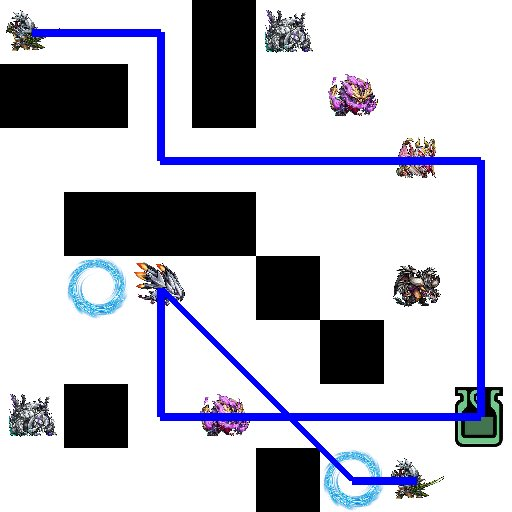

Verbose: Displaying static maze maze_manual_step_22.jpg in Jupyter
Verbose: Manual testing completed
Verbose: Pygame quit


In [ ]:
try:
    print("Verbose: Starting execution")
    if platform.system() == "Emscripten":
        print("Verbose: Running in Pyodide environment (note: image loading and file saving may fail)")
    else:
        print("Verbose: Running in local environment")
    setup()
    main()
except Exception as e:
    print(f"Verbose: Execution failed with error: {e}")
    raise
finally:
    pygame.quit()
    print("Verbose: Pygame quit")

### Ref3: Visualize Epsilon Decay

The code below graphs the epsilon decay over the episodes, and the total rewards per episode.

Epsilon Decay: We can see that throughout 100 episodes, the epsilon started from 1, and gradually decreased as if in a straight line all the way to around 0.60, indicating that epsilon decay did take place.

Total Reward Per Episode: Additionally, we see how each episode performed. In the early episodes, the agent actually had a consistent low yield of reward, but later on, there were peaks which showed that it had runs where it got high rewards. Overall, the peak seemed to have occured around episodes 75-80.

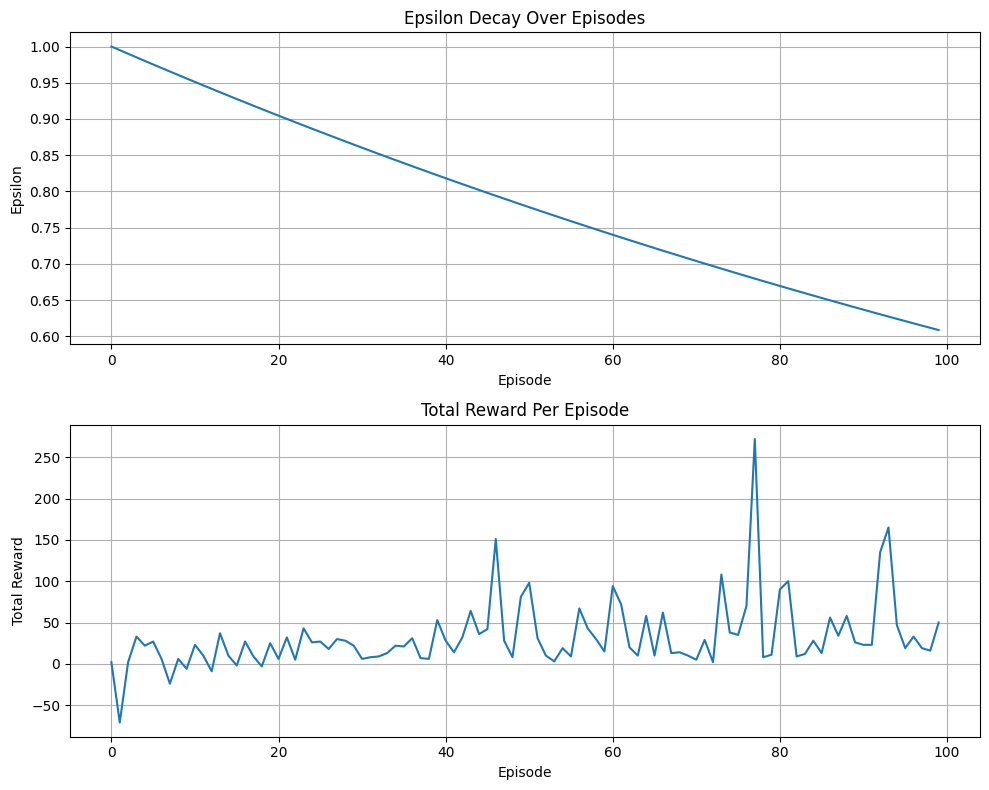

In [ ]:
# Ref3: Visualize Epsilon Decay

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(epsilons)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(rewards)
plt.title('Total Reward Per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.tight_layout()
plt.show()

### Ref6: Generate a performance dashboard

This performance dashboard consists of 4 graphs.

Average Reward Per Episode - Similar to the total reward. There's a slow start early on, but a convergence in the later episodes, with the highest peak being around episode 75-80, showing that the model did actually improve over time/episodes.

Success Rate Over Episodes - Moving on to success rates, early on the agent actually performed badly, having a low cumulative success rate, but as the episodes went be, slowly but surely the success rate converged to above 70%, meaning it can perform better than average.

Episode Lengths - To better show the epsilon decay in action, episode lengths tells us how long each episode loop takes in terms of actions. In line with the epsilon decay, we see that the episodes later on got faster and faster, signifying that the model slowly adapted to exploitation later on, while mostly exploring early on.

Q-table Change Over Episodes - This graph shows how much the q-table was updated. A higher value just means that the q-table got more optimal steps added to it. We can actually see that in action around episodes 10-40 where there are a lot of changes, but interestingly around episode 75-80, a particular episode skyrocketed and had a high value. This can indicate that a lot more optimal actions have been found, updating the Q-table by a lot.


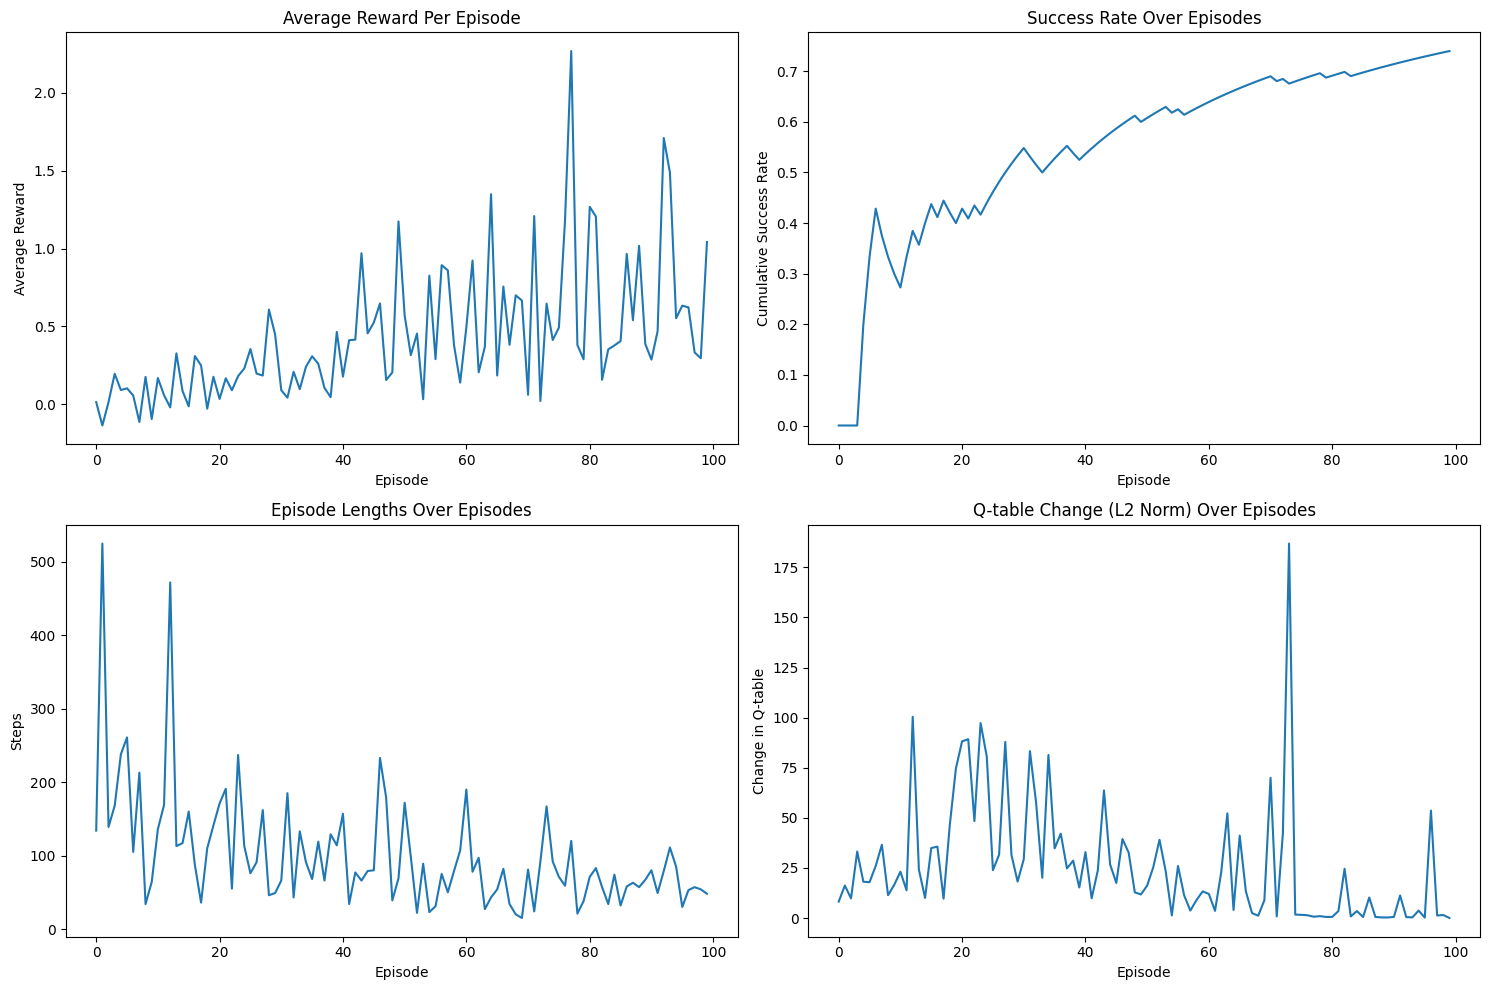

In [ ]:
# Ref6: Generate a performance dashboard with all plots in one figure
plt.figure(figsize=(15, 10))

# Graph Average Reward Per Episode
plt.subplot(2, 2, 1)
plt.plot(average_reward_per_episode)
plt.title('Average Reward Per Episode')
plt.xlabel('Episode')
plt.ylabel('Average Reward')

# Graph Success Rate Over Episodes
plt.subplot(2, 2, 2)
plt.plot(success_rate)
plt.title('Success Rate Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Cumulative Success Rate')

# Graph Episode Lengths
plt.subplot(2, 2, 3)
plt.plot(episode_lengths)
plt.title('Episode Lengths Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Steps')

# Graph Q-table Change Over Episodes
plt.subplot(2, 2, 4)
plt.plot(q_changes)
plt.title('Q-table Change (L2 Norm) Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Change in Q-table')

plt.tight_layout()
plt.show()


# Ref10: ACTION REPLAY

To see the replay in action, a simple call along with the action list done by the user is executed, showing the path the agent (user) took earlier.

Verbose: Entering replay_maze function
Verbose: Resetting environment
Verbose: Starting replay...
Verbose: Generating static maze visualization as maze_replay_start.jpg
Verbose: Static maze saved as maze_replay_start.jpg in /content


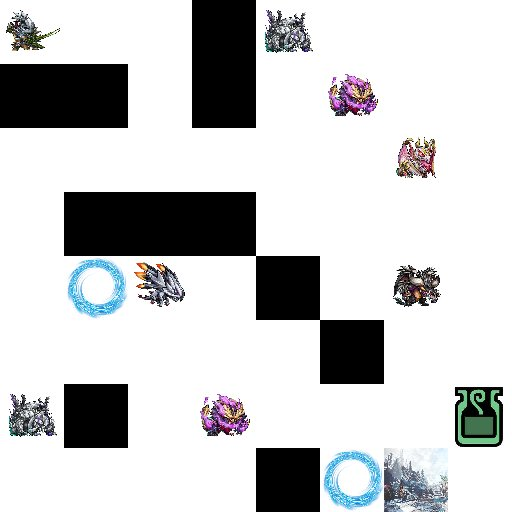

Verbose: Displaying static maze maze_replay_start.jpg in Jupyter
Verbose: Generating static maze visualization as maze_replay_step_1.jpg
Verbose: Static maze saved as maze_replay_step_1.jpg in /content


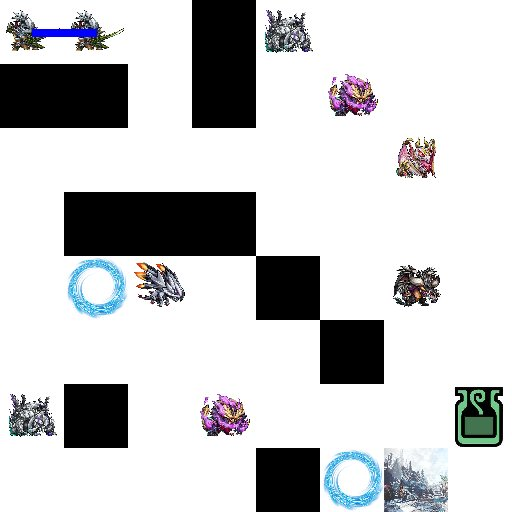

Verbose: Displaying static maze maze_replay_step_1.jpg in Jupyter
Verbose: Replay step 1, action: 1, state: 1, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_2.jpg
Verbose: Static maze saved as maze_replay_step_2.jpg in /content


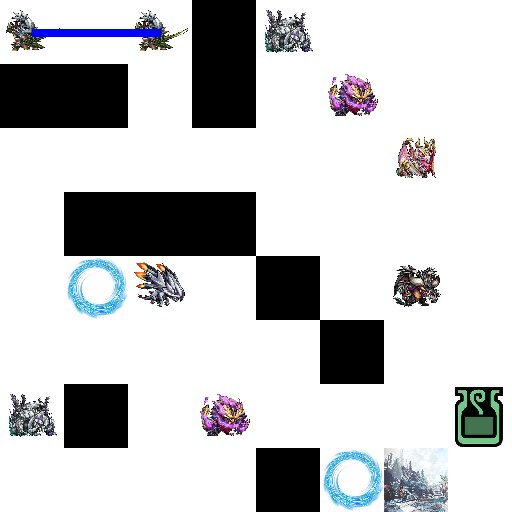

Verbose: Displaying static maze maze_replay_step_2.jpg in Jupyter
Verbose: Replay step 2, action: 1, state: 2, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_3.jpg
Verbose: Static maze saved as maze_replay_step_3.jpg in /content


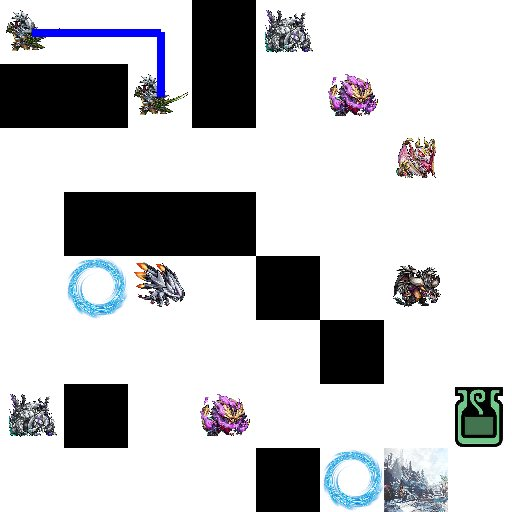

Verbose: Displaying static maze maze_replay_step_3.jpg in Jupyter
Verbose: Replay step 3, action: 3, state: 10, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_4.jpg
Verbose: Static maze saved as maze_replay_step_4.jpg in /content


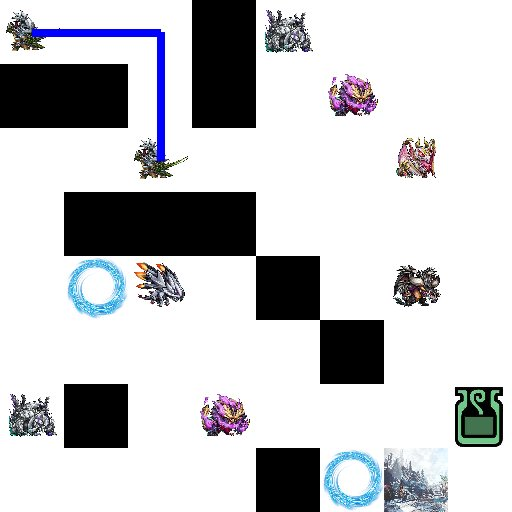

Verbose: Displaying static maze maze_replay_step_4.jpg in Jupyter
Verbose: Replay step 4, action: 3, state: 18, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_5.jpg
Verbose: Static maze saved as maze_replay_step_5.jpg in /content


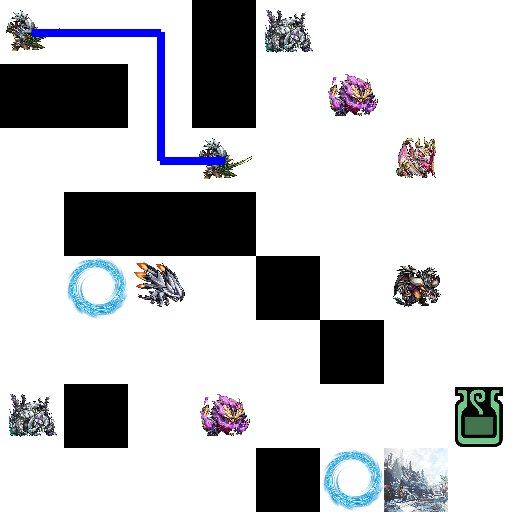

Verbose: Displaying static maze maze_replay_step_5.jpg in Jupyter
Verbose: Replay step 5, action: 1, state: 19, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_6.jpg
Verbose: Static maze saved as maze_replay_step_6.jpg in /content


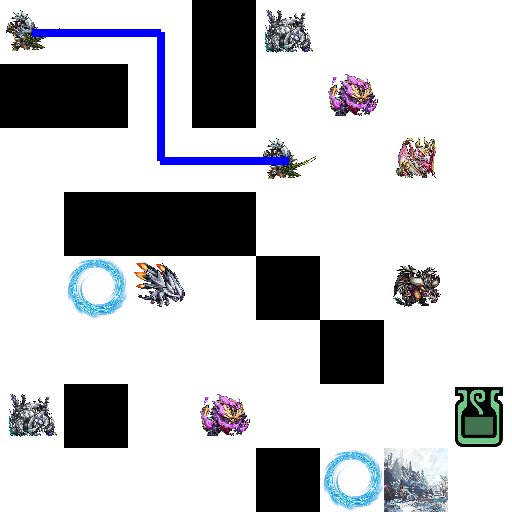

Verbose: Displaying static maze maze_replay_step_6.jpg in Jupyter
Verbose: Replay step 6, action: 1, state: 20, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_7.jpg
Verbose: Static maze saved as maze_replay_step_7.jpg in /content


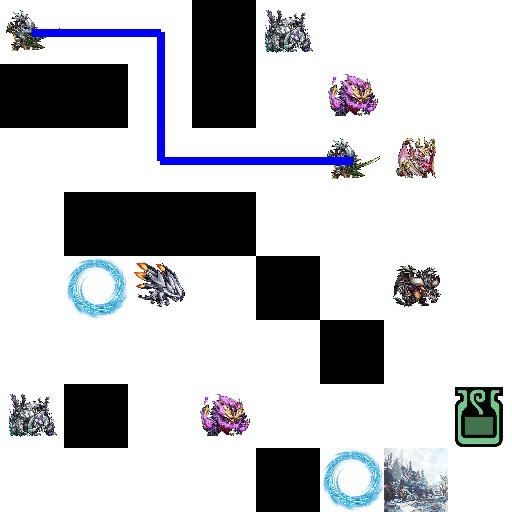

Verbose: Displaying static maze maze_replay_step_7.jpg in Jupyter
Verbose: Replay step 7, action: 1, state: 21, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_8.jpg
Verbose: Static maze saved as maze_replay_step_8.jpg in /content


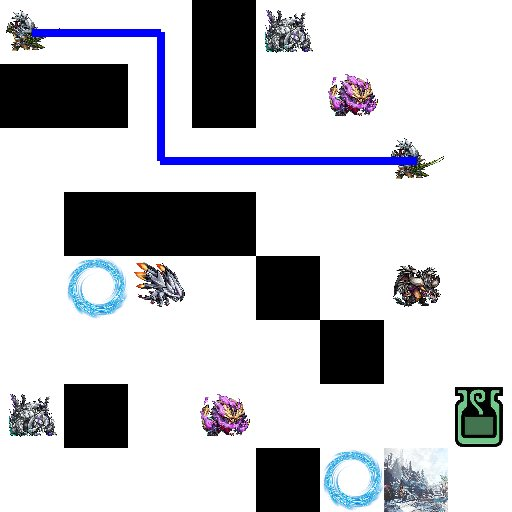

Verbose: Displaying static maze maze_replay_step_8.jpg in Jupyter
Verbose: Replay step 8, action: 1, state: 22, reward: -1, done: False
Verbose: Generating static maze visualization as maze_replay_step_9.jpg
Verbose: Static maze saved as maze_replay_step_9.jpg in /content


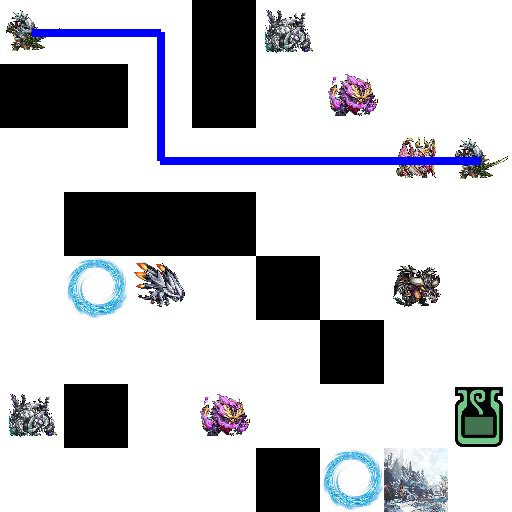

Verbose: Displaying static maze maze_replay_step_9.jpg in Jupyter
Verbose: Replay step 9, action: 1, state: 23, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_10.jpg
Verbose: Static maze saved as maze_replay_step_10.jpg in /content


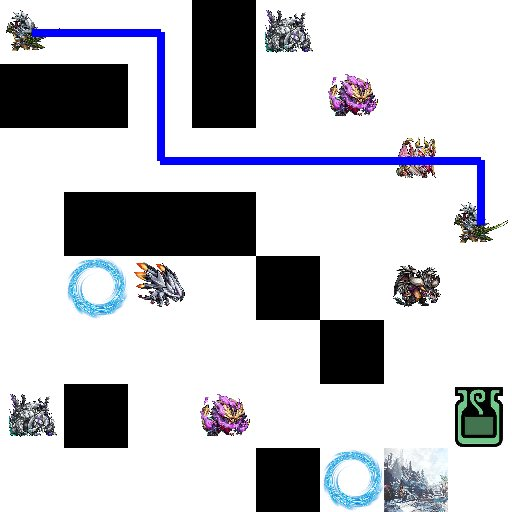

Verbose: Displaying static maze maze_replay_step_10.jpg in Jupyter
Verbose: Replay step 10, action: 3, state: 31, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_11.jpg
Verbose: Static maze saved as maze_replay_step_11.jpg in /content


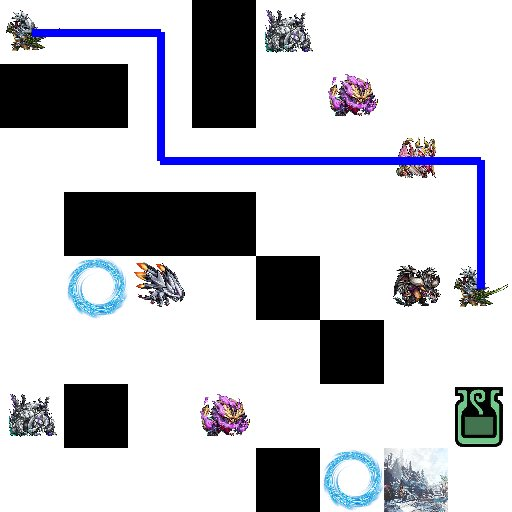

Verbose: Displaying static maze maze_replay_step_11.jpg in Jupyter
Verbose: Replay step 11, action: 3, state: 39, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_12.jpg
Verbose: Static maze saved as maze_replay_step_12.jpg in /content


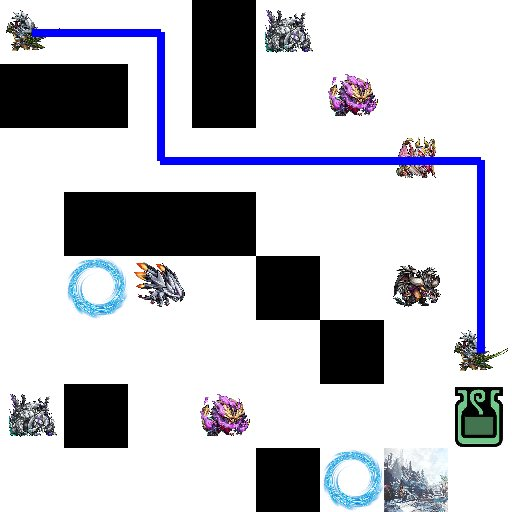

Verbose: Displaying static maze maze_replay_step_12.jpg in Jupyter
Verbose: Replay step 12, action: 3, state: 47, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_13.jpg
Verbose: Static maze saved as maze_replay_step_13.jpg in /content


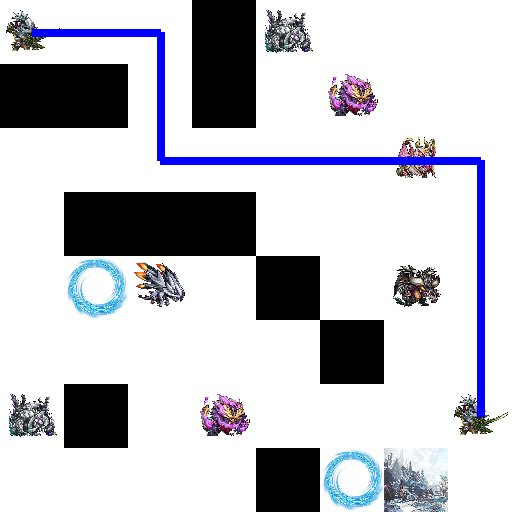

Verbose: Displaying static maze maze_replay_step_13.jpg in Jupyter
Verbose: Replay step 13, action: 3, state: 55, reward: 5, done: False
Verbose: Generating static maze visualization as maze_replay_step_14.jpg
Verbose: Static maze saved as maze_replay_step_14.jpg in /content


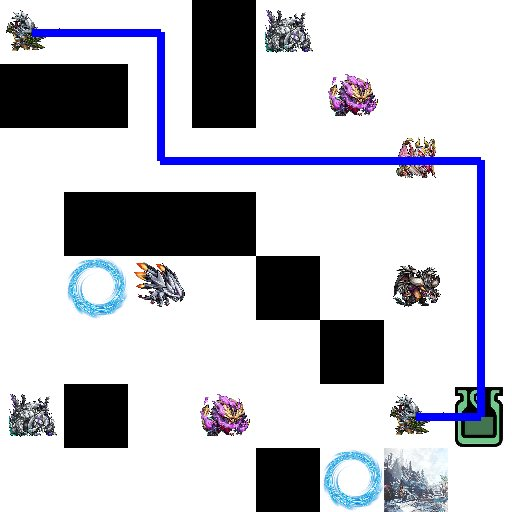

Verbose: Displaying static maze maze_replay_step_14.jpg in Jupyter
Verbose: Replay step 14, action: 0, state: 54, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_15.jpg
Verbose: Static maze saved as maze_replay_step_15.jpg in /content


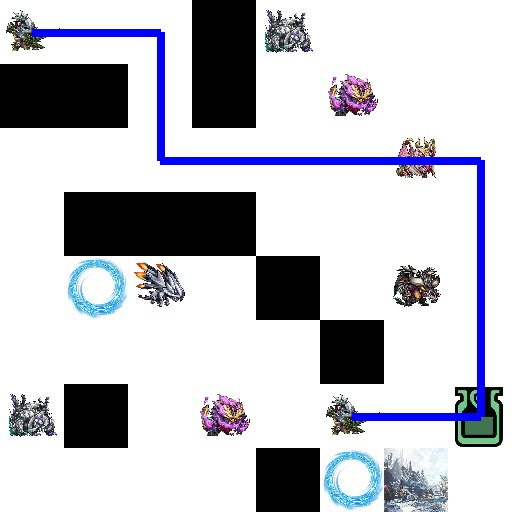

Verbose: Displaying static maze maze_replay_step_15.jpg in Jupyter
Verbose: Replay step 15, action: 0, state: 53, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_16.jpg
Verbose: Static maze saved as maze_replay_step_16.jpg in /content


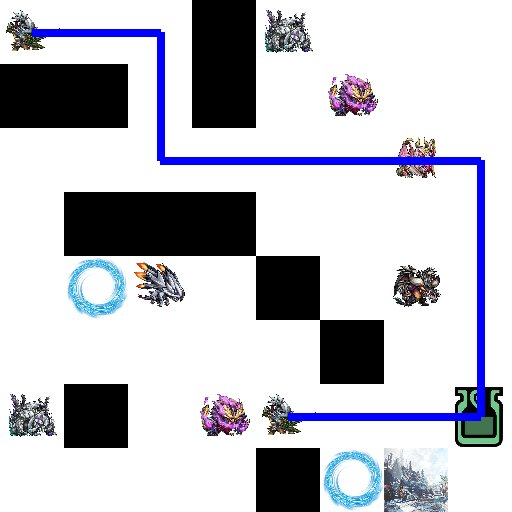

Verbose: Displaying static maze maze_replay_step_16.jpg in Jupyter
Verbose: Replay step 16, action: 0, state: 52, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_17.jpg
Verbose: Static maze saved as maze_replay_step_17.jpg in /content


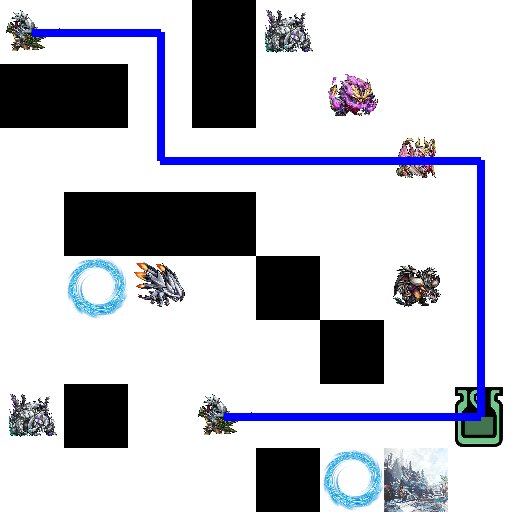

Verbose: Displaying static maze maze_replay_step_17.jpg in Jupyter
Verbose: Replay step 17, action: 0, state: 51, reward: -1, done: False
Verbose: Generating static maze visualization as maze_replay_step_18.jpg
Verbose: Static maze saved as maze_replay_step_18.jpg in /content


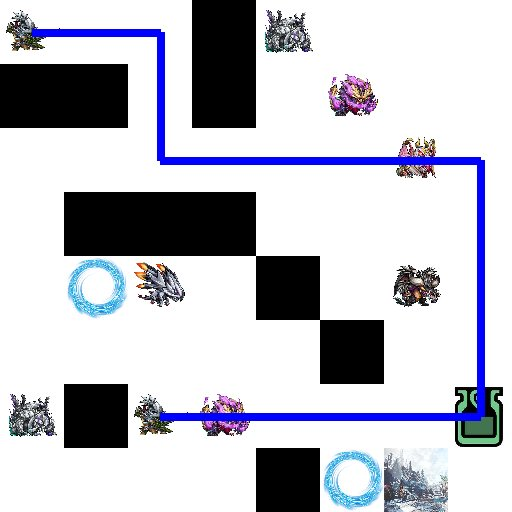

Verbose: Displaying static maze maze_replay_step_18.jpg in Jupyter
Verbose: Replay step 18, action: 0, state: 50, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_19.jpg
Verbose: Static maze saved as maze_replay_step_19.jpg in /content


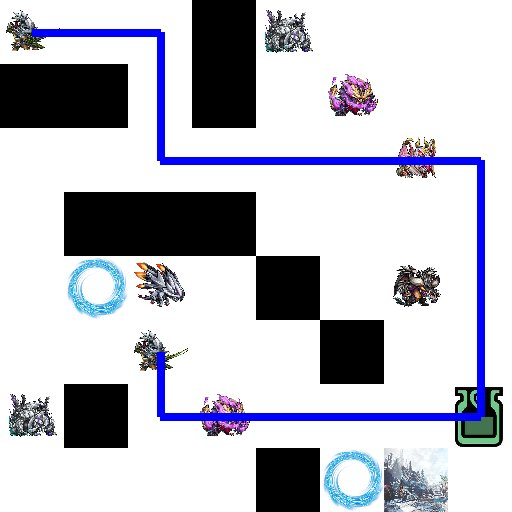

Verbose: Displaying static maze maze_replay_step_19.jpg in Jupyter
Verbose: Replay step 19, action: 2, state: 42, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_20.jpg
Verbose: Static maze saved as maze_replay_step_20.jpg in /content


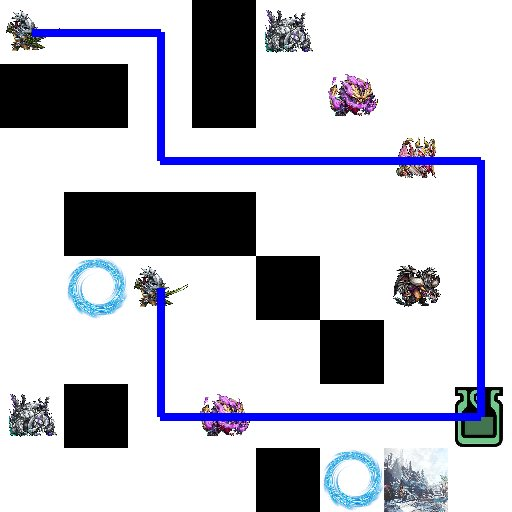

Verbose: Displaying static maze maze_replay_step_20.jpg in Jupyter
Verbose: Replay step 20, action: 2, state: 34, reward: -1, done: False
Verbose: Generating static maze visualization as maze_replay_step_21.jpg
Verbose: Static maze saved as maze_replay_step_21.jpg in /content


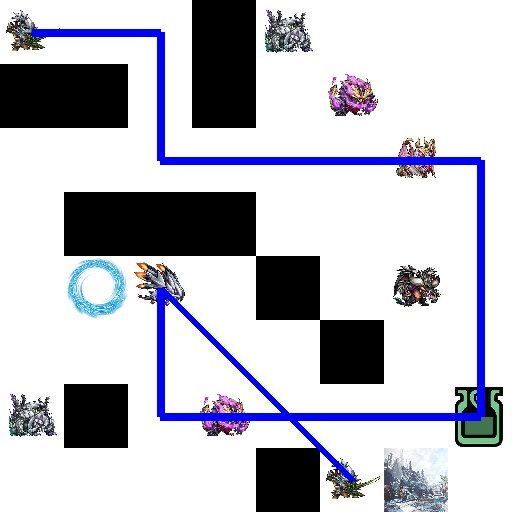

Verbose: Displaying static maze maze_replay_step_21.jpg in Jupyter
Verbose: Replay step 21, action: 0, state: 61, reward: 0, done: False
Verbose: Generating static maze visualization as maze_replay_step_22.jpg
Verbose: Static maze saved as maze_replay_step_22.jpg in /content


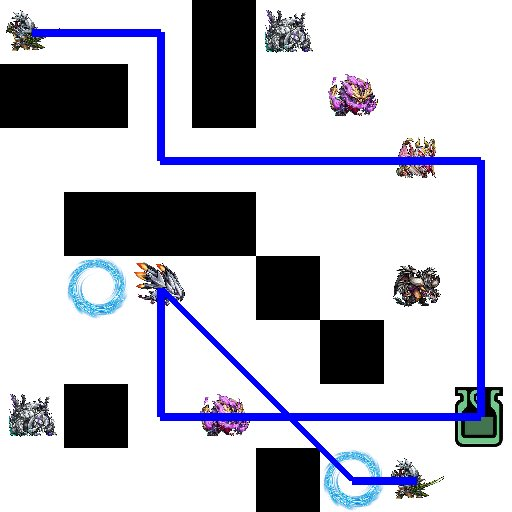

Verbose: Displaying static maze maze_replay_step_22.jpg in Jupyter
Verbose: Replay step 22, action: 1, state: 62, reward: 10, done: True
Verbose: Replay completed.


In [ ]:
# Ref10: ACTION REPLAY
replay_maze(action_list)

# SUMMARY

The notebook implements a reinforcement learning algorithm of Q-learning within a custom 8x8 grid maze-like environment. It begins by importing necessary libraries like `pygame`, `numpy`, and `matplotlib`. The environment class, `MazeEnv`, features a grid with a start ('S'), goal ('G'), reward ('R'), walls ('W'), traps ('T'), and portals ('P1', 'P2').

The environment uses Pygame for visualization, loading custom images for different cell types and displaying the agent's path. This also sets up Q-learning parameters, including alpha, gamma, and epsilon with decay. The main function runs the training loop for a defined number of episodes, implementing the epsilon-greedy strategy for action selection and updating the Q-table.

During training, performance metrics such as average reward per episode, success rate, and episode length are tracked. After training, a manual testing mode allows users to interact with the environment using keyboard input. The user can also see their past actions with the `replay_maze` function, utilizing a saved list of actions from the manual test, visualizes the path taken during the manual interaction.

Finally, the notebook visualizes the training progress through various plots, including epsilon decay, total reward per episode, average reward per episode, success rate, episode lengths, and Q-table changes.